### K-means clustering



In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.cluster import KMeans
glob_temp = np.arange(-0.2,6.8,0.1)

In [2]:
add = ''
#add= '_temp_above_1_1'

pd_exp_decay_fits_adv = pd.read_csv(f'fitted_glacier_response_to_global_temp_ch_complex_20yr_avg_period{add}.csv', index_col=0)
pd_exp_decay_fits_simple = pd.read_csv(f'fitted_glacier_response_to_global_temp_ch_simple_20yr_avg_period{add}.csv', index_col=0)

In [3]:
sns.__version__

'0.12.2'

In [4]:
df_resp_time_deltaT = pd.read_csv('median_resp_time_-50%_threshold25%_for_deltaT_rgi_reg.csv', index_col=0)

# k-means clustering with just one time dimension (i.e. year= 5000)


In [5]:
def exponential_decay_complex(x, a, b,c,d):
    exp_values_b = -b * x
    exp_values_d = -d * x**2
    return a * np.exp(exp_values_b) + c * np.exp(exp_values_d)#**c 

In [6]:
def exponential_decay(x, a, b):
    exp_values_b = -b * x
    return a * np.exp(exp_values_b) #+ c * np.exp(exp_values_d)#**c 

In [7]:
pd_exp_decay_fits_simple_5000 = pd_exp_decay_fits_simple.loc[pd_exp_decay_fits_simple.year ==5000]
pd_exp_decay_fits_simple_5000_values = pd.DataFrame(index = pd_exp_decay_fits_simple_5000.rgi_reg, columns= np.arange(-0.2,6.801,0.1))
j = 0
for a, b in zip(pd_exp_decay_fits_simple_5000['a_simple'].values, pd_exp_decay_fits_simple_5000['b_simple'].values):
    v_time_series = exponential_decay(np.arange(-0.2,6.801,0.1),a,b)
    pd_exp_decay_fits_simple_5000_values.iloc[j] =  v_time_series
    j+=1

## Let's use a fitted timeseries as features (then we don't need to do any normalisation)

In [10]:
regions = pd_exp_decay_fits_simple_5000_values.index.values
data = pd_exp_decay_fits_simple_5000_values.values

# Perform K-means clustering
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k)

# just to ensure that the same cluster numbering is applied...
labels = ['test']
while np.any(labels!=[0, 1, 0, 1, 0, 0, 0, 0, 3, 0, 3, 0, 3, 1, 1, 0, 2, 1, 1, 1]):
    kmeans.fit(data)

    # Get the resulting centroids and labels
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

# Print the resulting centroids and labels
print("Centroids:")
print(centroids)
print("Labels:")
print(labels)

pd_exp_decay_fits_simple_5000_values[f'kmeans_cluster_{k}'] = labels

Centroids:
[[1.10826495e+02 1.03003483e+02 9.57754178e+01 8.90942263e+01
  8.29159030e+01 7.72001543e+01 7.19100750e+01 6.70118520e+01
  6.24744968e+01 5.82695998e+01 5.43711076e+01 5.07551201e+01
  4.73997048e+01 4.42847287e+01 4.13917037e+01 3.87036470e+01
  3.62049527e+01 3.38812751e+01 3.17194224e+01 2.97072595e+01
  2.78336192e+01 2.60882209e+01 2.44615972e+01 2.29450260e+01
  2.15304687e+01 2.02105138e+01 1.89783255e+01 1.78275965e+01
  1.67525045e+01 1.57476732e+01 1.48081360e+01 1.39293027e+01
  1.31069297e+01 1.23370919e+01 1.16161575e+01 1.09407647e+01
  1.03078000e+01 9.71437947e+00 9.15782979e+00 8.63567252e+00
  8.14560868e+00 7.68550491e+00 7.25338077e+00 6.84739695e+00
  6.46584460e+00 6.10713536e+00 5.76979228e+00 5.45244146e+00
  5.15380436e+00 4.87269064e+00 4.60799169e+00 4.35867459e+00
  4.12377656e+00 3.90239981e+00 3.69370690e+00 3.49691631e+00
  3.31129846e+00 3.13617197e+00 2.97090029e+00 2.81488846e+00
  2.66758023e+00 2.52845533e+00 2.39702699e+00 2.27283957e+

In [11]:
pd_exp_decay_fits_simple_5000_values['a_simple'] = pd_exp_decay_fits_simple_5000['a_simple'].values
pd_exp_decay_fits_simple_5000_values['b_simple'] = pd_exp_decay_fits_simple_5000['b_simple'].values
pd_exp_decay_fits_simple_5000_values = pd_exp_decay_fits_simple_5000_values.reset_index()

In [12]:
# committed volume (at global temperature +1.1°C)
pd_exp_decay_fits_simple_5000_values[r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]'] = exponential_decay(1.1,pd_exp_decay_fits_simple_5000_values['a_simple'].values, pd_exp_decay_fits_simple_5000_values['b_simple'].values)
# temperature where the double of 'V$_{eq}$(+1.1°C)' is lost
# deltaT = -b*log(0.5*r'V$_{eq}$(+1.1°C)' / a)
pd_exp_decay_fits_simple_5000_values[r'ΔT(ΔV=0.5*V$_{eq,rel,ΔT=+1.1°C}$ [in °C]'] = np.log(0.5*pd_exp_decay_fits_simple_5000_values[r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]'].values / pd_exp_decay_fits_simple_5000_values['a_simple'].values)/-pd_exp_decay_fits_simple_5000['b_simple'].values

pd_exp_decay_fits_simple_5000_values['region'] = 'RGI' + pd_exp_decay_fits_simple_5000_values['rgi_reg']
pd_exp_decay_fits_simple_5000_values.loc[pd_exp_decay_fits_simple_5000_values['rgi_reg']=='All','region'] = 'Globally'

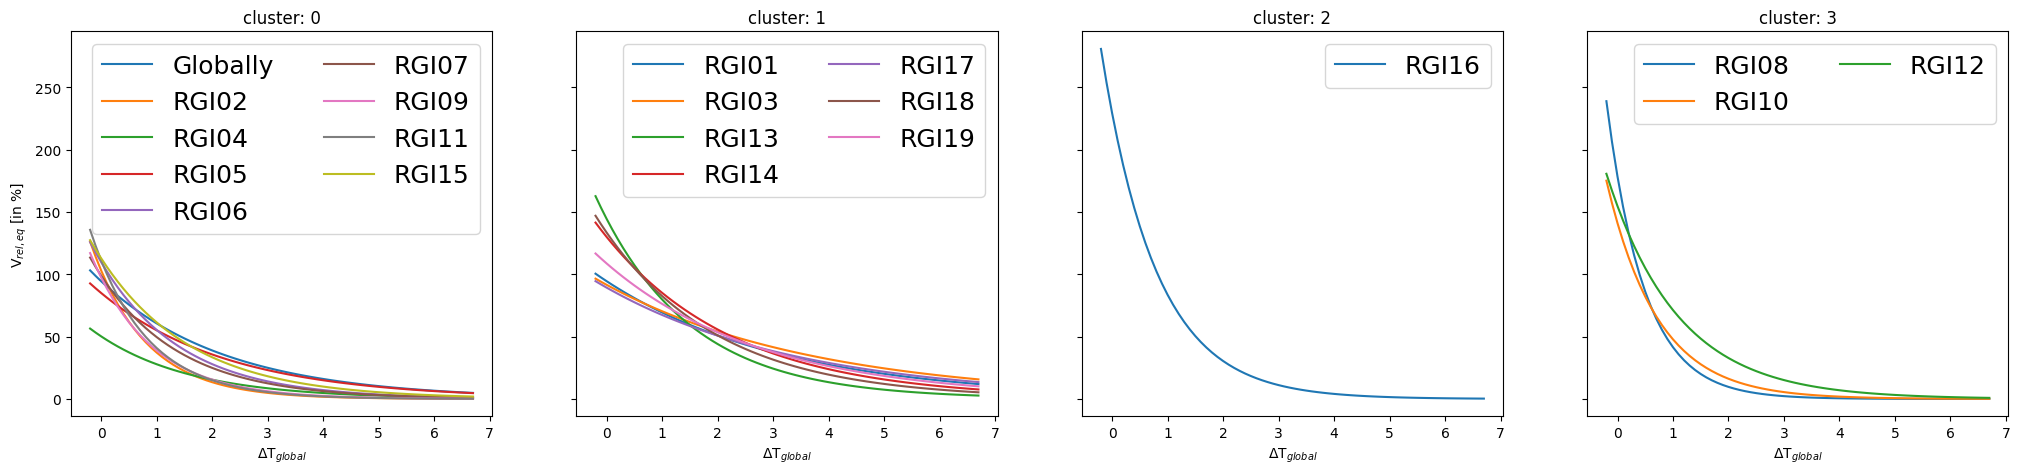

In [13]:
fig,axs = plt.subplots(1,4,figsize=(25,5), sharey=True)
for k in [0,1,2,3]:
    pd_sel = pd_exp_decay_fits_simple_5000_values.loc[pd_exp_decay_fits_simple_5000_values.kmeans_cluster_4 == k]
    ax = axs[k]
    for reg in pd_sel.region.values:
        pd_sel_reg = pd_sel.loc[pd_sel.region==reg]
        a,b = pd_sel_reg[['a_simple', 'b_simple']].values.squeeze()
        ax.plot(glob_temp, exponential_decay(glob_temp,a,b), label=reg)
        ax.legend(ncol=2, fontsize=18)
axs[0].set_ylabel(r'V$_{rel,eq}$ [in %]')
for j,ax in enumerate(axs):
    ax.set_xlabel(r'ΔT$_{global}$')
    ax.set_title(f'cluster: {j}')

In [14]:
df = pd_exp_decay_fits_simple_5000_values.copy()

In [15]:
# get response time
rgi_reg_clus = df.iloc[1:][['region', 'kmeans_cluster_4']]
rgi_reg_clus.index = rgi_reg_clus.region
df_resp_time_deltaT.index = df_resp_time_deltaT.rgi_reg
for r in rgi_reg_clus.index:
    df_resp_time_deltaT.loc[r,'kmeans_cluster_4'] = rgi_reg_clus.loc[r,'kmeans_cluster_4']
    
resp_time_deltaT_1_5deg = df_resp_time_deltaT.where((df_resp_time_deltaT.temp_ch_ipcc>1.3) & (df_resp_time_deltaT.temp_ch_ipcc<1.7)).dropna()
resp_time_deltaT_3_0deg = df_resp_time_deltaT.where((df_resp_time_deltaT.temp_ch_ipcc>2.8) & (df_resp_time_deltaT.temp_ch_ipcc<3.2)).dropna()
#resp_time_deltaT_3_0deg.index = resp_time_deltaT_3_0deg.temp_ch_ipcc
print(len(resp_time_deltaT_1_5deg.temp_ch_ipcc.unique()), len(resp_time_deltaT_3_0deg.temp_ch_ipcc.unique()))

resp_time_deltaT_1_5deg = df_resp_time_deltaT.where((df_resp_time_deltaT.temp_ch_ipcc>1.3) & (df_resp_time_deltaT.temp_ch_ipcc<1.7)).dropna().reset_index(drop=True).groupby('rgi_reg').median()
resp_time_deltaT_3_0deg = df_resp_time_deltaT.where((df_resp_time_deltaT.temp_ch_ipcc>2.8) & (df_resp_time_deltaT.temp_ch_ipcc<3.2)).dropna().reset_index(drop=True).groupby('rgi_reg').median()
#resp_time_deltaT_3_0deg.index = resp_time_deltaT_3_0deg.temp_ch_ipcc
resp_time_deltaT_sel = resp_time_deltaT_1_5deg.copy()
resp_time_deltaT_sel = resp_time_deltaT_sel.rename(columns={'resp_time_-50%':'resp_time_-50%_1_5_deg', })
resp_time_deltaT_sel['resp_time_-50%_3_0_deg'] = resp_time_deltaT_3_0deg.loc[resp_time_deltaT_sel.index.values]['resp_time_-50%']
#sns.scatterplot(data = resp_time_deltaT_sel, x= 'resp_time_-50%_1_5_deg', y='resp_time_-50%_3_0_deg', marker='o',s=200, hue='kmeans_cluster_4')

17 5


In [16]:
df.index = df.region
df.loc[resp_time_deltaT_sel.index.values, ['resp_time_-50%_1_5_deg','resp_time_-50%_3_0_deg']] = resp_time_deltaT_sel[['resp_time_-50%_1_5_deg','resp_time_-50%_3_0_deg']].values

/tmp/ipykernel_3741353/2065472028.py:31: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(data=df, y='a_simple', x='b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
/tmp/ipykernel_3741353/2065472028.py:48: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax=sns.scatterplot(data=df, y=r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]',
/tmp/ipykernel_3741353/2065472028.py:75: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax=sns.scatterplot(data=df, y='resp_time_-50%_1_5_deg',
/tmp/ipykernel_3741353/2065472028.py:88: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax=sns.scatterplot(data=df, y='resp_time_-50%_3_0_deg',
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

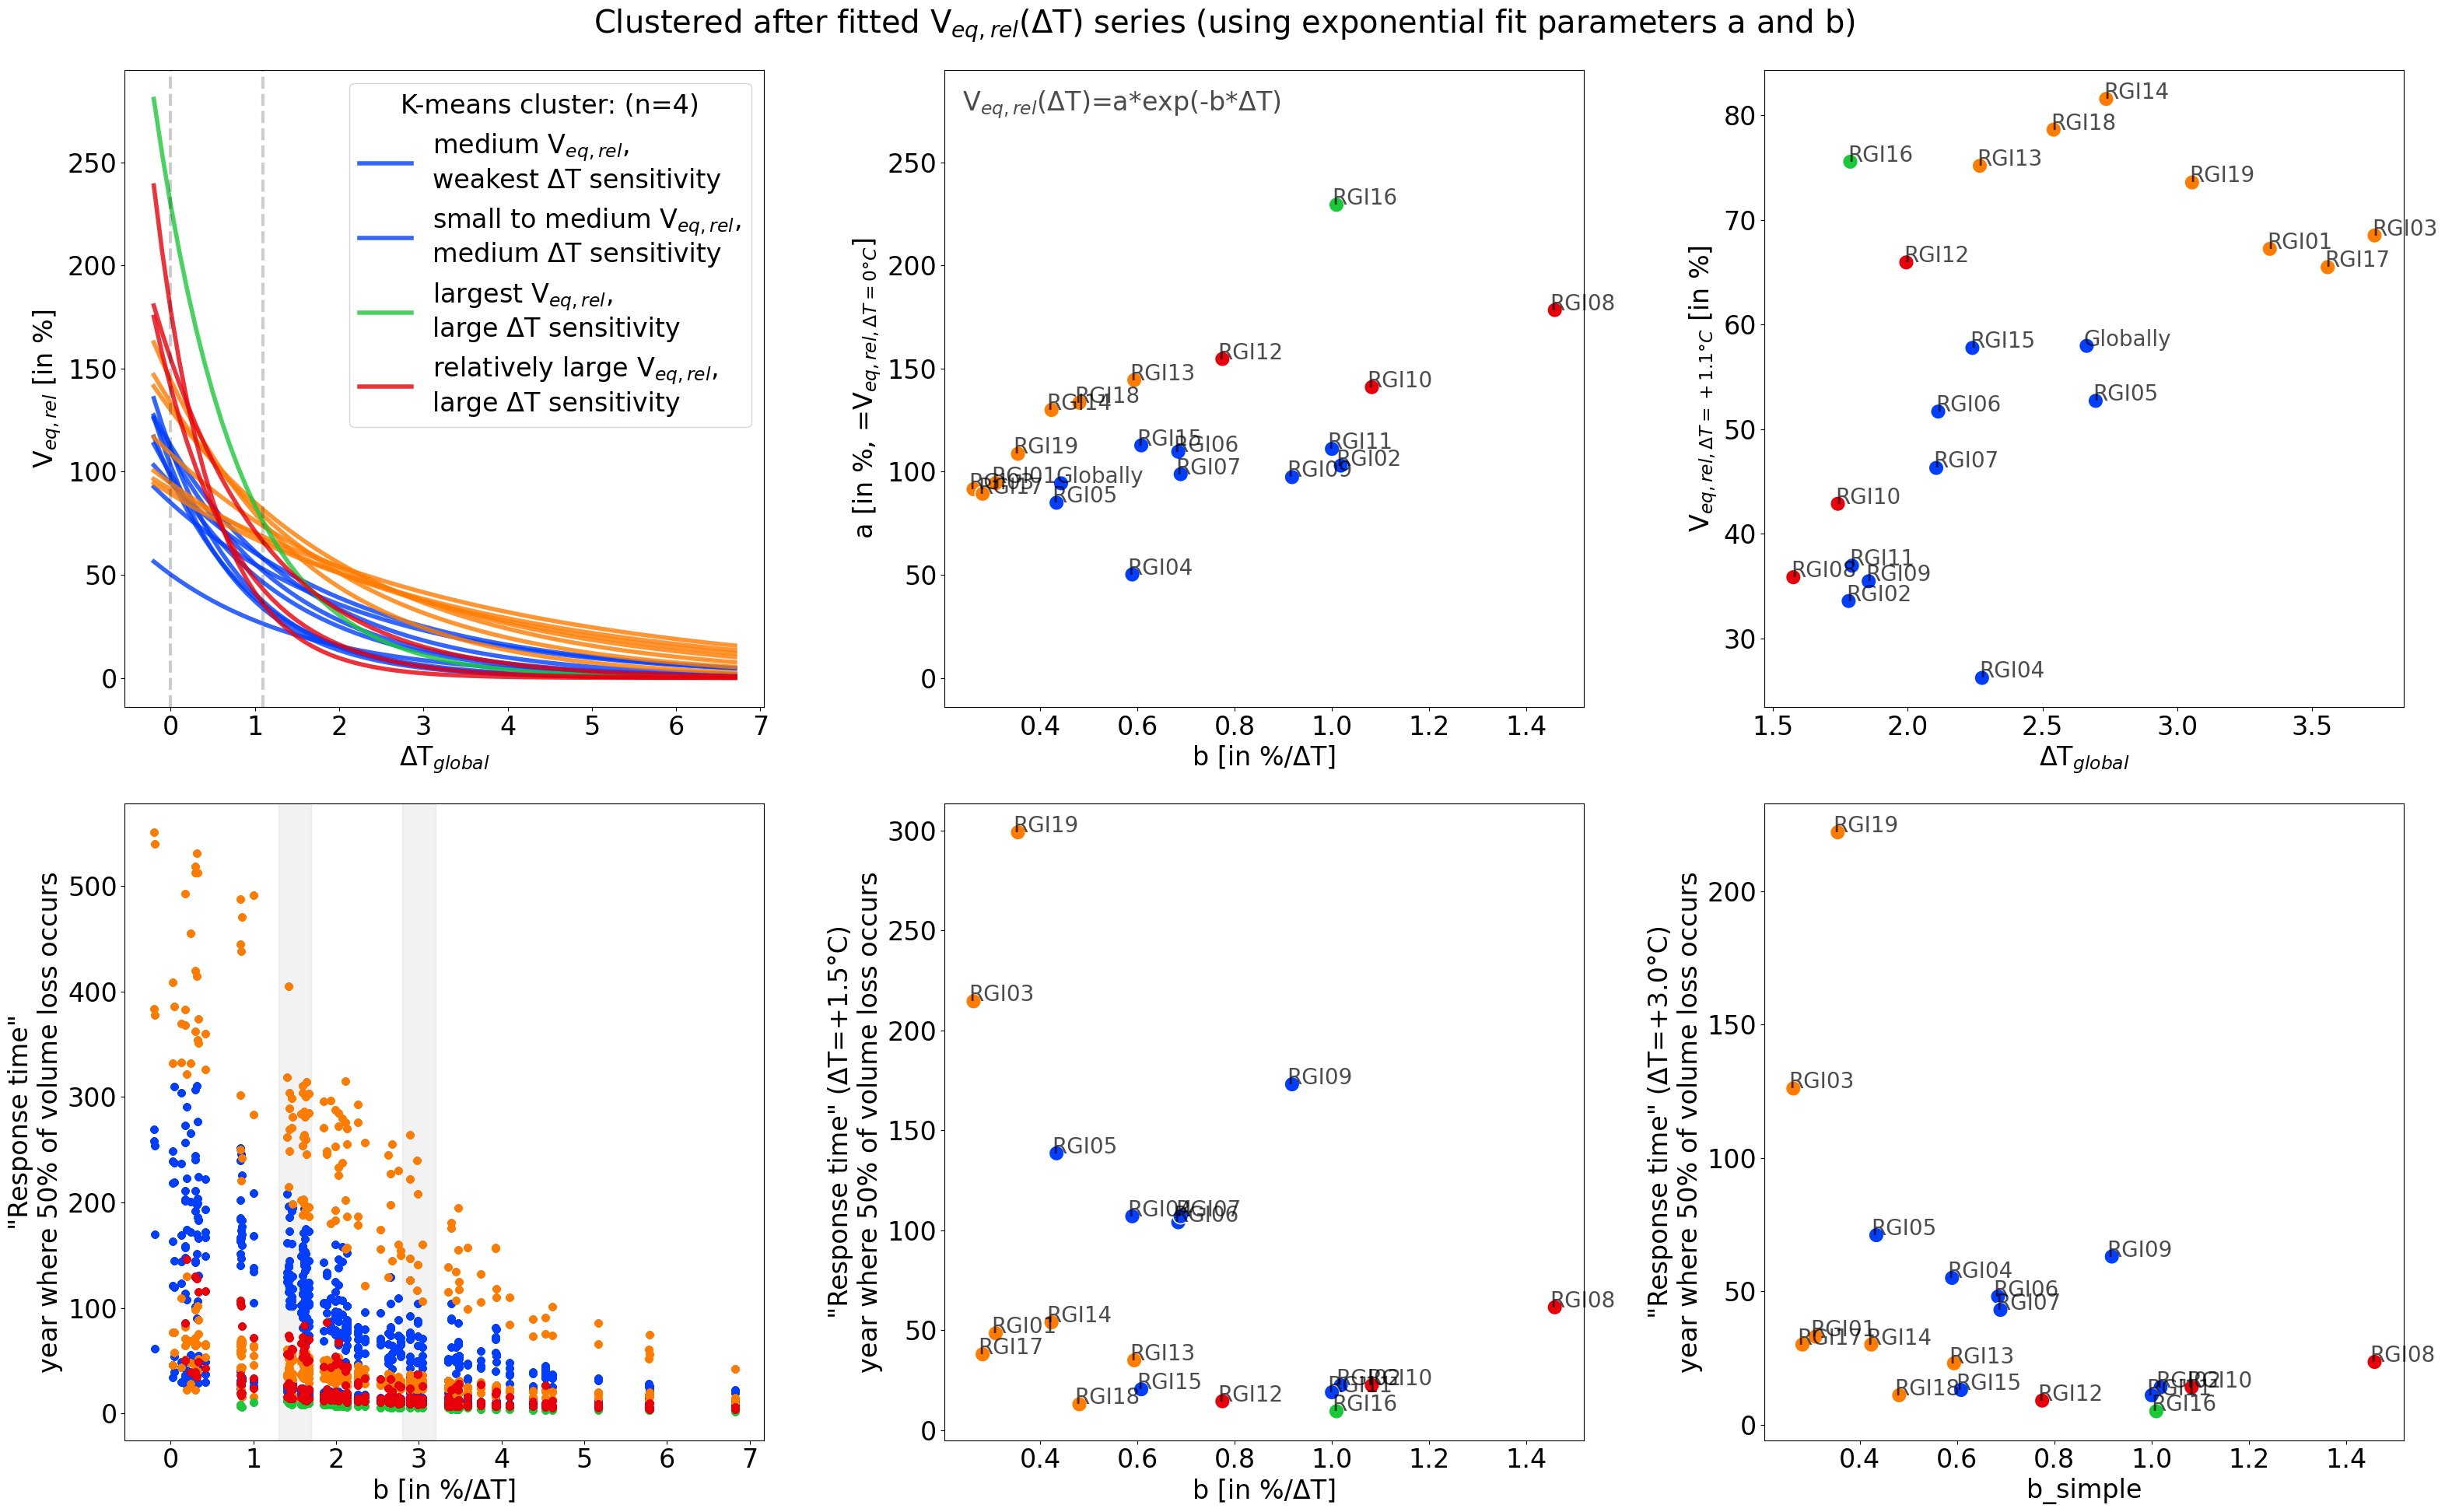

In [17]:
# from https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
def plotlabel(xvar, yvar, label):
    ax.text(xvar-0.01, yvar+0.01, label, alpha=0.7, fontsize=20)
plt.rc('font', size=24)  

plt.figure(figsize=(32,20))

ax=plt.subplot(231)
for k in [0,1,2,3]:
    pd_sel = df.loc[df.kmeans_cluster_4 == k]
    for reg in pd_sel.region:
        pd_sel_reg = pd_sel.loc[pd_sel.region==reg]
        a,b = pd_sel_reg[['a_simple', 'b_simple']].values.squeeze()
        ax.plot(glob_temp, exponential_decay(glob_temp,a,b), label=reg, color=sns.color_palette('bright')[k],lw=4, alpha = 0.8)
handles, labels = ax.get_legend_handles_labels()
handles_l = handles[0], handles[7],handles[16],handles[18]
labels_long_cluster = [r'medium V$_{eq,rel}$'+',\nweakest ΔT sensitivity', r'small to medium V$_{eq,rel}$'+',\nmedium ΔT sensitivity',
                       r'largest V$_{eq,rel}$'+',\nlarge ΔT sensitivity', r'relatively large V$_{eq,rel}$'+',\nlarge ΔT sensitivity']
ax.legend(handles_l,labels_long_cluster, title = 'K-means cluster: (n=4)')        

ax.set_ylabel(r'V$_{eq,rel}$ [in %]')
ax.set_xlabel(r'ΔT$_{global}$')

ylim0,ylim1 = ax.get_ylim()
plt.axvline(0,ls='--', alpha = 0.2,lw=3, color='black')

plt.axvline(1.1,ls='--', alpha = 0.2,lw=3, color='black')


plt.subplot(232)
ax = sns.scatterplot(data=df, y='a_simple', x='b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
df.apply(lambda x: plotlabel(x['b_simple'],  x['a_simple'], x['region']), axis=1)
ax.text(0.24,275, r'V$_{eq,rel}$(ΔT)=a*exp(-b*ΔT)', alpha=0.7, fontsize=24)
ax.set_xlabel('b [in %/ΔT]')
ax.set_ylabel(r'a [in %, =V$_{eq,rel,ΔT=0°C}$]')
leg=plt.legend(title='K-means\ncluster:\n(n=4)', loc='lower right')
leg.remove()
ax.set_ylim(ylim0,ylim1)
#plt.subplot(122)
#ax=sns.scatterplot(data=pd_exp_decay_fits_simple_5000, x=r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]', y=r'b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('tab10'), s=200)
#ax.set_ylabel('b [in %/ΔT]')
#pd_exp_decay_fits_simple_5000.apply(lambda x: plotlabel(x[r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]'],  x['b_simple'], x['region']), axis=1)
#plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper right')



plt.subplot(233)
ax=sns.scatterplot(data=df, y=r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]',
                   x=r'ΔT(ΔV=0.5*V$_{eq,rel,ΔT=+1.1°C}$ [in °C]', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
df.apply(lambda x: plotlabel(x[r'ΔT(ΔV=0.5*V$_{eq,rel,ΔT=+1.1°C}$ [in °C]'], x[r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]'],  x['region']), axis=1)
leg = plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper left')
leg.remove()
ax.set_xlabel(r'ΔT$_{global}$')


#plt.tight_layout()


plt.subplot(234)
ax = plt.gca()
for k in [0,1,2,3]:
    df_resp_time_deltaT_sel = df_resp_time_deltaT.loc[df_resp_time_deltaT.kmeans_cluster_4 == k]
    for reg in df_resp_time_deltaT_sel.rgi_reg:
        pd_sel_reg = df_resp_time_deltaT_sel.loc[df_resp_time_deltaT_sel.rgi_reg==reg]
        ax.plot(pd_sel_reg['temp_ch_ipcc'], pd_sel_reg['resp_time_-50%'], 'o', color=sns.color_palette('bright')[k], alpha = 0.6)
plt.ylabel('"Response time"\nyear where 50% of volume loss occurs')
ax.set_xlabel('b [in %/ΔT]')
plt.axvspan(1.3,1.7, color='grey', alpha = 0.1)

plt.axvspan(2.8,3.2, color='grey', alpha = 0.1)
        
        
plt.subplot(235)
#plt.subplot(133)
ax=sns.scatterplot(data=df, y='resp_time_-50%_1_5_deg',
                   x=r'b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
df.apply(lambda x: plotlabel(x[r'b_simple'], x['resp_time_-50%_1_5_deg'],  x['region']), axis=1)
leg = plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper left')
leg.remove()
plt.ylabel('"Response time" (ΔT=+1.5°C)\nyear where 50% of volume loss occurs')
#plt.tight_layout()
ax.set_xlabel('b [in %/ΔT]')



#plt.subplot(133)
plt.subplot(236)
ax=sns.scatterplot(data=df, y='resp_time_-50%_3_0_deg',
                   x=r'b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
df.apply(lambda x: plotlabel(x[r'b_simple'], x['resp_time_-50%_3_0_deg'],  x['region']), axis=1)
leg = plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper left')
leg.remove()
plt.ylabel('"Response time" (ΔT=+3.0°C)\nyear where 50% of volume loss occurs')

plt.suptitle('Clustered after fitted V$_{eq,rel}$(ΔT) series (using exponential fit parameters a and b)')
plt.tight_layout()

plt.savefig('figures/3_k_means_clustering/kmeans_clustering_after_Veq_fitted_series.png')

/tmp/ipykernel_3741353/1803093889.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax=sns.scatterplot(data=df, y='resp_time_-50%_3_0_deg',


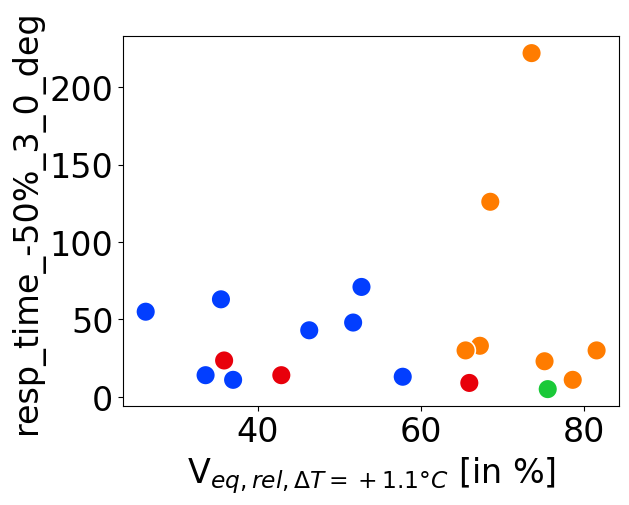

In [18]:
#plt.subplot(133)
ax=sns.scatterplot(data=df, y='resp_time_-50%_3_0_deg',
                   x=r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
#df.apply(lambda x: plotlabel(x[r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]'], x['resp_time_-50%_1_5_deg'],  x['region']), axis=1)
leg = plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper left')
leg.remove()
#plt.tight_layout()

/tmp/ipykernel_3741353/1851373533.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax=sns.scatterplot(data=df, y='resp_time_-50%_1_5_deg',
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


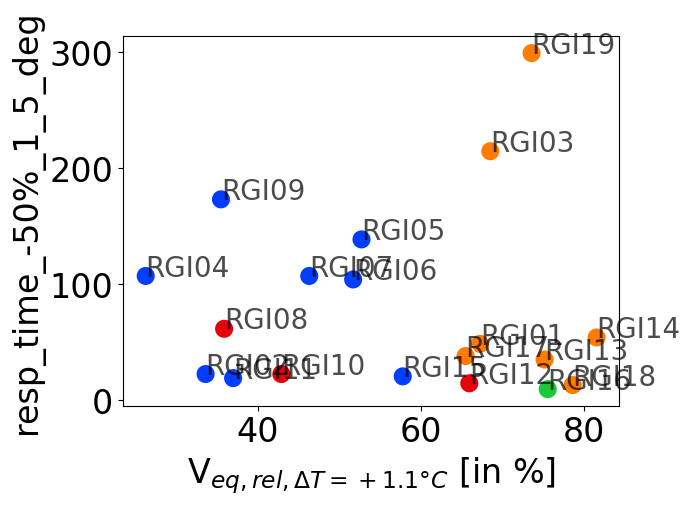

In [19]:
#plt.subplot(133)
ax=sns.scatterplot(data=df, y='resp_time_-50%_1_5_deg',
                   x=r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
df.apply(lambda x: plotlabel(x[r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]'], x['resp_time_-50%_1_5_deg'],  x['region']), axis=1)
leg = plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper left')
leg.remove()
#plt.tight_layout()

## K-means clustering with normalised a and b as features

In [8]:
import sklearn

**simple fit**

In [ ]:
pd_exp_decay_fits_simple_5000 = pd_exp_decay_fits_simple.loc[pd_exp_decay_fits_simple.year ==5000]

for var in ['a_simple', 'b_simple']:
    pd_exp_decay_fits_simple_5000[var+'_norm'] = sklearn.preprocessing.normalize([pd_exp_decay_fits_simple_5000[var].values]).squeeze()
regions = pd_exp_decay_fits_simple_5000.rgi_reg.values
data = pd_exp_decay_fits_simple_5000[['a_simple_norm', 'b_simple_norm']].values
# Perform K-meansa clustering
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k)
labels = ['test']
while np.any(labels != np.array([0, 0, 1, 0, 0, 0, 2, 2, 3, 1, 1, 1, 2, 2, 2, 2, 3, 0, 2, 0])):
    kmeans.fit(data)

    # Get the resulting centroids and labels
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

# Print the resulting centroids and labels
print("Centroids:")
print(centroids)
print("Labels:")
print(labels)

pd_exp_decay_fits_simple_5000[f'kmeans_cluster_{k}'] = labels

/tmp/ipykernel_3640764/3591444806.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_exp_decay_fits_simple_5000[var+'_norm'] = sklearn.preprocessing.normalize([pd_exp_decay_fits_simple_5000[var].values]).squeeze()
/tmp/ipykernel_3640764/3591444806.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_exp_decay_fits_simple_5000[var+'_norm'] = sklearn.preprocessing.normalize([pd_exp_decay_fits_simple_5000[var].values]).squeeze()
/tmp/ipykernel_3640764/3591444806.py:11: FutureWarning: elementwise comparis

In [ ]:
# committed volume (at global temperature +1.1°C)
pd_exp_decay_fits_simple_5000[r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]'] = exponential_decay(1.1,pd_exp_decay_fits_simple_5000['a_simple'].values, pd_exp_decay_fits_simple_5000['b_simple'].values)
# temperature where the double of 'V$_{eq}$(+1.1°C)' is lost
# deltaT = -b*log(0.5*r'V$_{eq}$(+1.1°C)' / a)
pd_exp_decay_fits_simple_5000[r'ΔT(ΔV=0.5*V$_{eq,rel,ΔT=+1.1°C}$ [in °C]'] = np.log(0.5*pd_exp_decay_fits_simple_5000[r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]'] / pd_exp_decay_fits_simple_5000['a_simple'])/-pd_exp_decay_fits_simple_5000['b_simple']

pd_exp_decay_fits_simple_5000['region'] = pd_exp_decay_fits_simple_5000['rgi_reg'] #let's not use the 'RGI'
pd_exp_decay_fits_simple_5000.loc[pd_exp_decay_fits_simple_5000['rgi_reg']=='All','region'] = 'Globally'

In [ ]:
df = pd_exp_decay_fits_simple_5000.copy()

In [ ]:
df_resp_time_deltaT = pd.read_csv('median_resp_time_-50%_threshold25%_for_deltaT_rgi_reg.csv', index_col=0)


In [ ]:
region_l = []
for r in df_resp_time_deltaT.rgi_reg:
    region_l.append(r[3:])
df_resp_time_deltaT['region'] = region_l

In [ ]:
varis = ['temp_ch_ipcc', 'resp_time_-50%', 'region',
       'kmeans_cluster_4']

In [ ]:
# get response time
rgi_reg_clus = df.iloc[1:][['region', 'kmeans_cluster_4']]
rgi_reg_clus.index = rgi_reg_clus.region
df_resp_time_deltaT.index = df_resp_time_deltaT.region
for r in rgi_reg_clus.index:
    df_resp_time_deltaT.loc[r,'kmeans_cluster_4'] = rgi_reg_clus.loc[r,'kmeans_cluster_4']
    
resp_time_deltaT_1_5deg = df_resp_time_deltaT.where((df_resp_time_deltaT.temp_ch_ipcc>1.3) & (df_resp_time_deltaT.temp_ch_ipcc<1.7)).dropna()
resp_time_deltaT_3_0deg = df_resp_time_deltaT.where((df_resp_time_deltaT.temp_ch_ipcc>2.8) & (df_resp_time_deltaT.temp_ch_ipcc<3.2)).dropna()
#resp_time_deltaT_3_0deg.index = resp_time_deltaT_3_0deg.temp_ch_ipcc
print(len(resp_time_deltaT_1_5deg.temp_ch_ipcc.unique()), len(resp_time_deltaT_3_0deg.temp_ch_ipcc.unique()))

resp_time_deltaT_1_5deg = df_resp_time_deltaT.where((df_resp_time_deltaT.temp_ch_ipcc>1.3) & (df_resp_time_deltaT.temp_ch_ipcc<1.7)).dropna().reset_index(drop=True).groupby('region')[varis].median()
resp_time_deltaT_3_0deg = df_resp_time_deltaT.where((df_resp_time_deltaT.temp_ch_ipcc>2.8) & (df_resp_time_deltaT.temp_ch_ipcc<3.2)).dropna().reset_index(drop=True).groupby('region')[varis].median()
#resp_time_deltaT_3_0deg.index = resp_time_deltaT_3_0deg.temp_ch_ipcc
resp_time_deltaT_sel = resp_time_deltaT_1_5deg.copy()
resp_time_deltaT_sel = resp_time_deltaT_sel.rename(columns={'resp_time_-50%':'resp_time_-50%_1_5_deg', })
resp_time_deltaT_sel['resp_time_-50%_3_0_deg'] = resp_time_deltaT_3_0deg.loc[resp_time_deltaT_sel.index.values]['resp_time_-50%']
#sns.scatterplot(data = resp_time_deltaT_sel, x= 'resp_time_-50%_1_5_deg', y='resp_time_-50%_3_0_deg', marker='o',s=200, hue='kmeans_cluster_4')

In [ ]:
resp_time_deltaT_sel['ratio_resp_time_1_5_vs_3_0'] = resp_time_deltaT_sel['resp_time_-50%_1_5_deg'] / resp_time_deltaT_sel['resp_time_-50%_3_0_deg']
sns.scatterplot(data = resp_time_deltaT_sel, x= 'resp_time_-50%_1_5_deg', y='ratio_resp_time_1_5_vs_3_0', marker='o',s=200, hue='kmeans_cluster_4',
                palette=sns.color_palette('bright'))

In [ ]:
df.index = df.region
df.loc[resp_time_deltaT_sel.index.values, ['resp_time_-50%_1_5_deg','resp_time_-50%_3_0_deg']] = resp_time_deltaT_sel[['resp_time_-50%_1_5_deg','resp_time_-50%_3_0_deg']].values

In [ ]:
# from https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
def plotlabel(xvar, yvar, label):
    ax.text(xvar-0.01, yvar+0.01, label, alpha=0.7, fontsize=20)
    
def plotlabel_b(xvar, yvar, label):
    ax.text(xvar-0.01, yvar-8, label, alpha=0.7, fontsize=20)
plt.rc('font', size=26)  

plt.figure(figsize=(32,20))

ax=plt.subplot(231)
for k in [0,1,2,3]:
    pd_sel = df.loc[df.kmeans_cluster_4 == k]
    for reg in pd_sel.region:
        pd_sel_reg = pd_sel.loc[pd_sel.region==reg]
        a,b = pd_sel_reg[['a_simple', 'b_simple']].values.squeeze()
        ax.plot(glob_temp, exponential_decay(glob_temp,a,b), label=reg,
                color=sns.color_palette('bright')[k],lw=4, alpha = 0.8)
handles, labels = ax.get_legend_handles_labels()
handles_l = handles[0], handles[7],handles[16],handles[18]
labels_long_cluster = [r'small V$_{eq,rel}$'+',\nweakest ΔT sensitivity', 
                       r'medium V$_{eq,rel}$'+',\nmedium ΔT sensitivity', 
                       r'medium V$_{eq,rel}$'+',\nweak ΔT sensitivity',
                       r'large V$_{eq,rel}$'+',\nlarge ΔT sensitivity']
ax.legend(handles_l,labels_long_cluster, title = 'K-means cluster: (n=4)\nmedian of glacier models')        

ax.set_ylabel(r'V$_{eq,rel}$ [in %]')
ax.set_xlabel(r'ΔT$_{global}$')

ylim0,ylim1 = ax.get_ylim()
plt.axvline(0,ls='--', alpha = 0.2,lw=3, color='black')

plt.axvline(1.1,ls='--', alpha = 0.2,lw=3, color='black')


plt.subplot(232)
ax = sns.scatterplot(data=df, y='a_simple', x='b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
df.loc[df.region!='17'].apply(lambda x: plotlabel(x['b_simple'],  x['a_simple'], x['region']), axis=1)

df.loc[df.region=='17'].apply(lambda x: plotlabel_b(x['b_simple'],  x['a_simple'], x['region']), axis=1)

ax.text(0.24,275, r'V$_{eq,rel}$(ΔT)=a*exp(-b*(ΔT-1.1))', alpha=0.7, fontsize=26)
ax.set_xlabel('b [in %/ΔT]')
ax.set_ylabel(r'a [in %, =V$_{eq,rel,ΔT=+1.1°C}$]')
leg=plt.legend(title='K-means\ncluster:\n(n=4)\nmedian of glacier models', loc='lower right')
leg.remove()
ax.set_ylim(ylim0,ylim1)
#plt.subplot(122)
#ax=sns.scatterplot(data=pd_exp_decay_fits_simple_5000, x=r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]', y=r'b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('tab10'), s=200)
#ax.set_ylabel('b [in %/ΔT]')
#pd_exp_decay_fits_simple_5000.apply(lambda x: plotlabel(x[r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]'],  x['b_simple'], x['region']), axis=1)
#plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper right')



plt.subplot(233)
ax=sns.scatterplot(data=df, y=r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]',
                   x=r'ΔT(ΔV=0.5*V$_{eq,rel,ΔT=+1.1°C}$ [in °C]', hue='kmeans_cluster_4',
                   palette=sns.color_palette('bright'), s=200)
df.apply(lambda x: plotlabel(x[r'ΔT(ΔV=0.5*V$_{eq,rel,ΔT=+1.1°C}$ [in °C]'],
                             x[r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]'],  x['region']), axis=1)
leg = plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper left')
leg.remove()
ax.set_xlabel(r'ΔT(0.5*V$_{eq,rel,ΔT=+1.1°C}$) [in °C]')




plt.subplot(234)
ax = plt.gca()
for k in [0,1,2,3]:
    df_resp_time_deltaT_sel = df_resp_time_deltaT.loc[df_resp_time_deltaT.kmeans_cluster_4 == k]
    for reg in df_resp_time_deltaT_sel.rgi_reg:
        pd_sel_reg = df_resp_time_deltaT_sel.loc[df_resp_time_deltaT_sel.rgi_reg==reg]
        ax.plot(pd_sel_reg['temp_ch_ipcc'], pd_sel_reg['resp_time_-50%'], 'o', color=sns.color_palette('bright')[k], alpha = 0.6)
plt.ylabel('"Response time"\nyear where 50% of volume loss occurs')
ax.set_xlabel(r'ΔT$_{global}$')
plt.axvspan(1.3,1.7, color='grey', alpha = 0.1)
plt.axvspan(2.8,3.2, color='grey', alpha = 0.1)
        
        
plt.subplot(235)
#plt.subplot(133)
ax=sns.scatterplot(data=df, y='resp_time_-50%_1_5_deg',
                   x=r'b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
df.apply(lambda x: plotlabel(x[r'b_simple'], x['resp_time_-50%_1_5_deg'],  x['region']), axis=1)
leg = plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper left')
leg.remove()
plt.ylabel('"Response time" (ΔT=+1.5°C)\nyear where 50% of volume loss occurs')
#plt.tight_layout()
ax.set_xlabel('b [in %/ΔT]')


#plt.subplot(133)
plt.subplot(236)
ax=sns.scatterplot(data=df, y='resp_time_-50%_3_0_deg',
                   x=r'b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
df.apply(lambda x: plotlabel(x[r'b_simple'], x['resp_time_-50%_3_0_deg'],  x['region']), axis=1)
leg = plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper left')
leg.remove()
plt.ylabel('"Response time" (ΔT=+3.0°C)\nyear where 50% of volume loss occurs')
ax.set_xlabel('b [in %/ΔT]')


plt.suptitle('Clustered after normalised exponential fit parameters (a and b)')
plt.tight_layout()
plt.savefig(f'figures/3_k_means_clustering/kmeans_clustering_after_Veq_params_a_b{add}.png')

/tmp/ipykernel_3741353/2475730273.py:36: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(data=df, y='a_simple', x='b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
/tmp/ipykernel_3741353/2475730273.py:56: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax=sns.scatterplot(data=df, y=r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]',
/tmp/ipykernel_3741353/2475730273.py:81: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax=sns.scatterplot(data=df, y='resp_time_-50%_1_5_deg',
/tmp/ipykernel_3741353/2475730273.py:93: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax=sns.scatterplot(data=df, y='resp_time_-50%_3_0_deg',
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

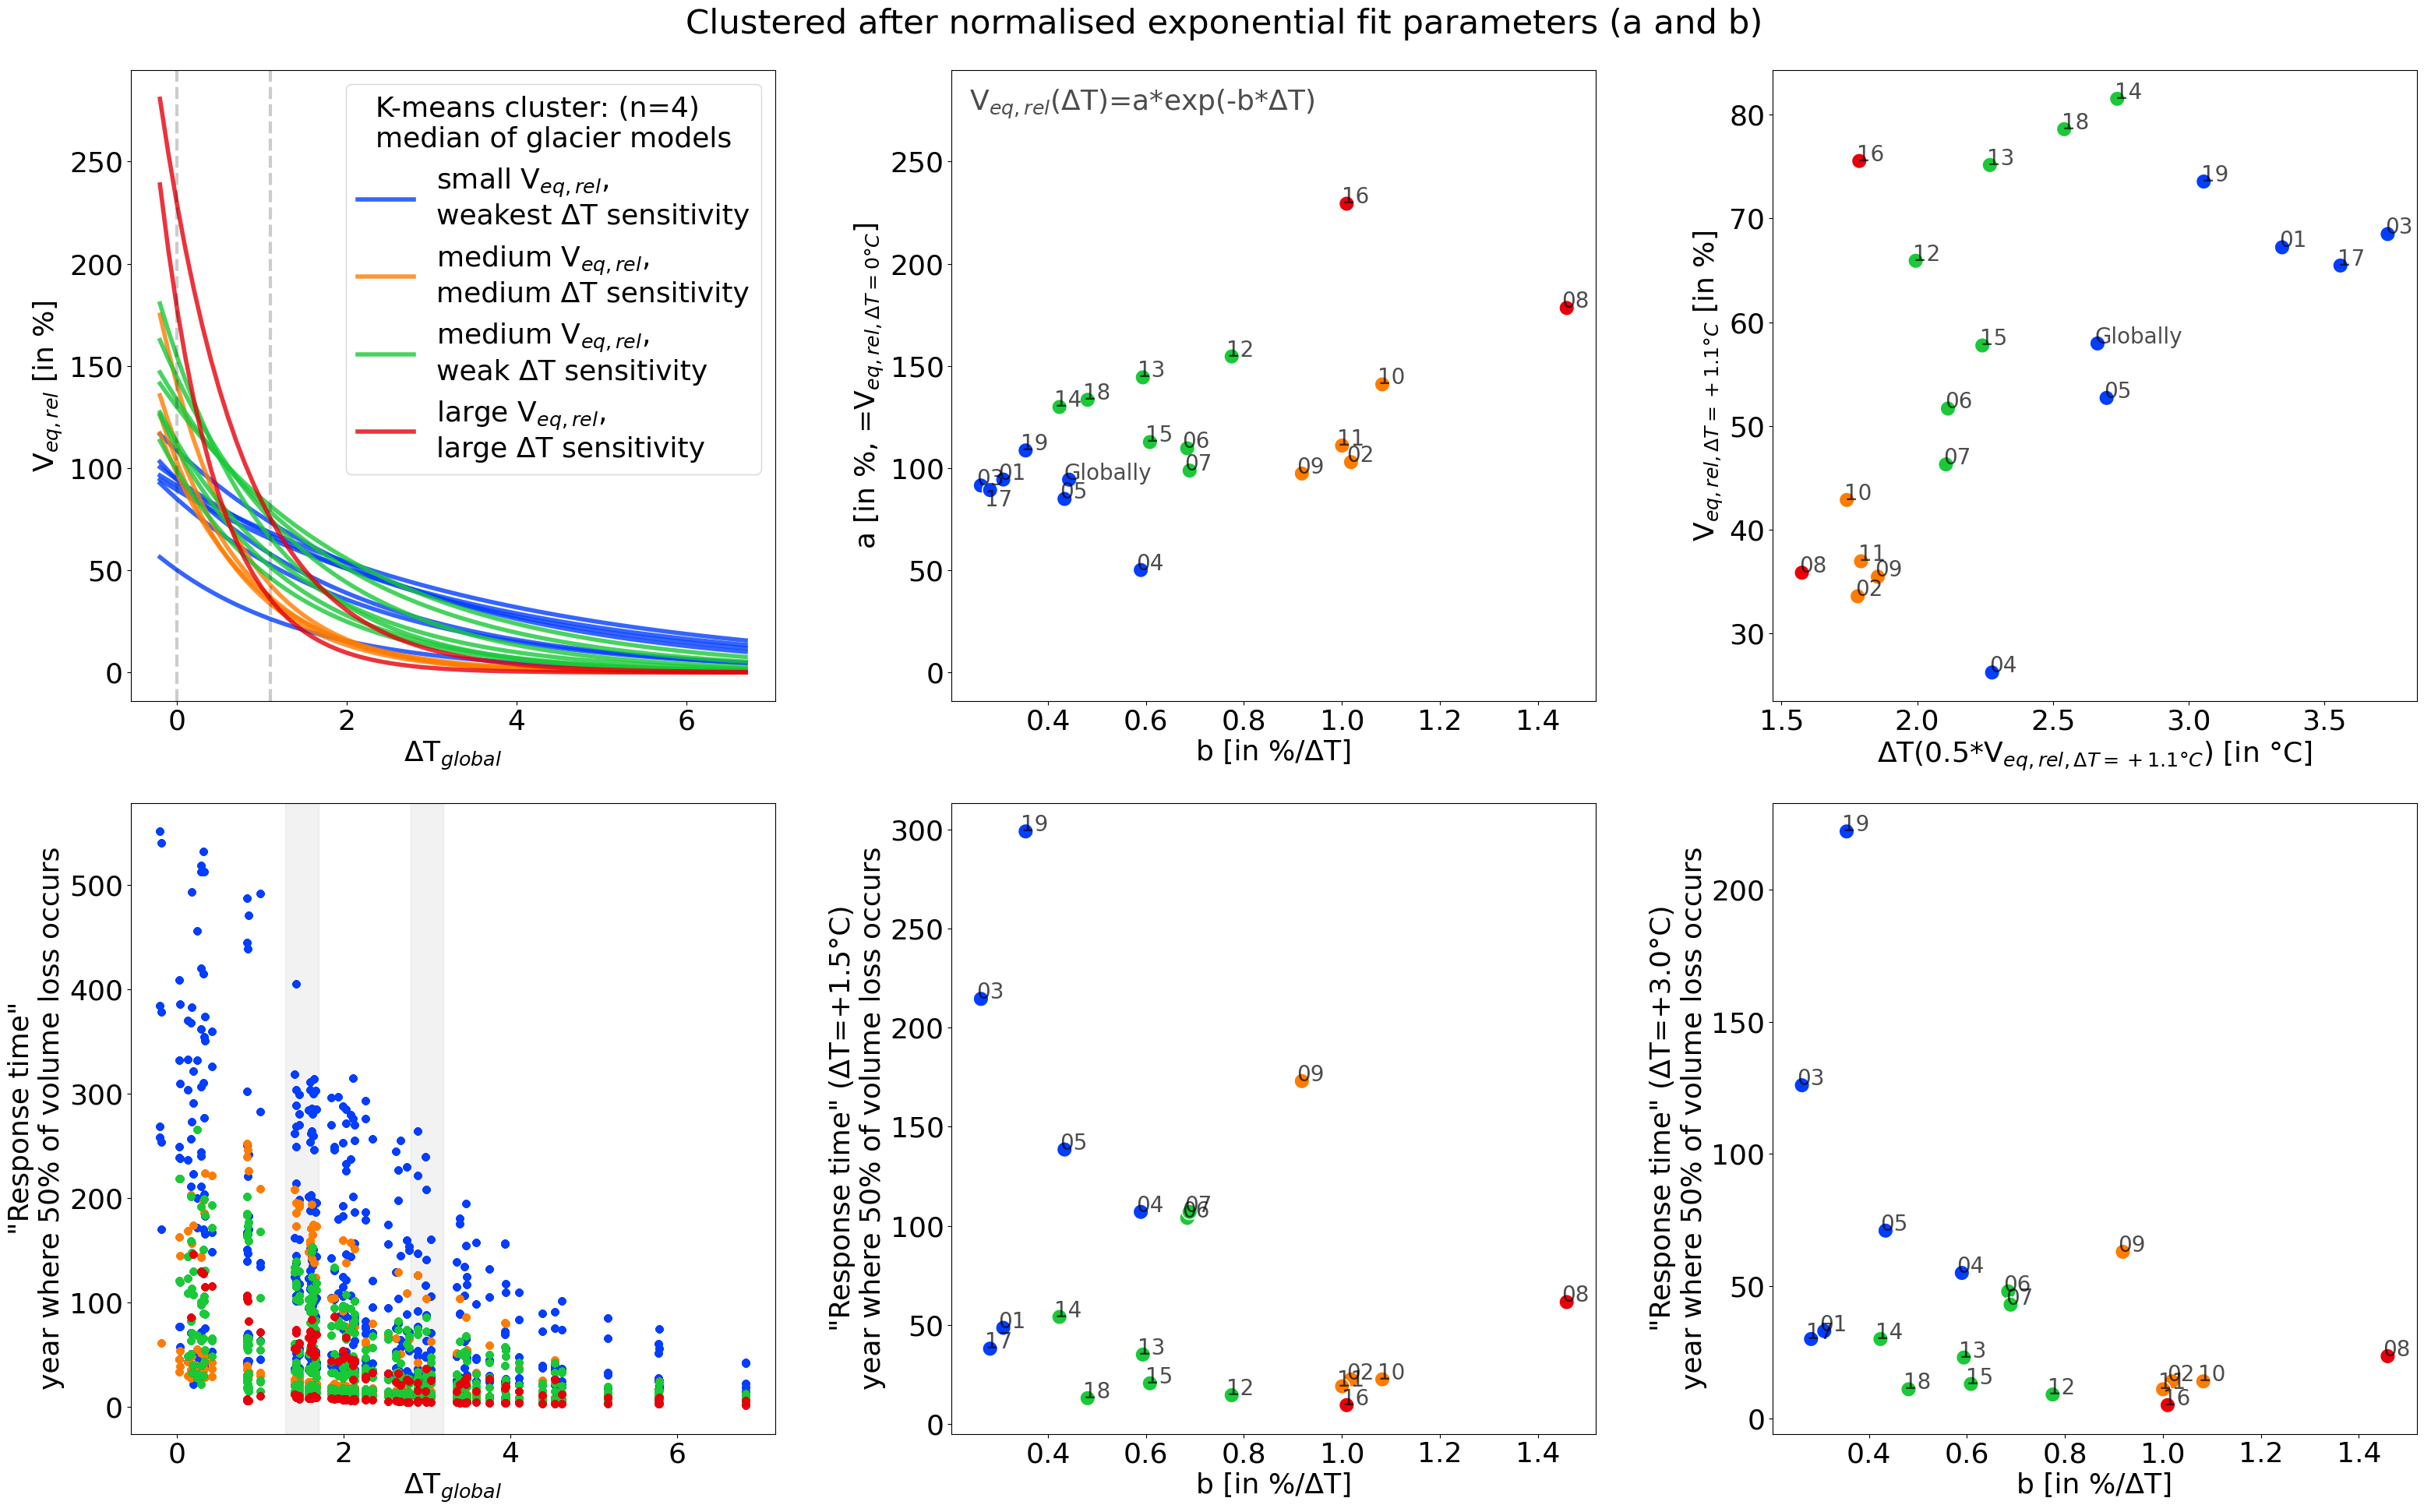

In [30]:
# from https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
def plotlabel(xvar, yvar, label):
    ax.text(xvar-0.01, yvar+0.01, label, alpha=0.7, fontsize=20)
    
def plotlabel_b(xvar, yvar, label):
    ax.text(xvar-0.01, yvar-8, label, alpha=0.7, fontsize=20)
plt.rc('font', size=26)  

plt.figure(figsize=(32,20))

ax=plt.subplot(231)
for k in [0,1,2,3]:
    pd_sel = df.loc[df.kmeans_cluster_4 == k]
    for reg in pd_sel.region:
        pd_sel_reg = pd_sel.loc[pd_sel.region==reg]
        a,b = pd_sel_reg[['a_simple', 'b_simple']].values.squeeze()
        ax.plot(glob_temp, exponential_decay(glob_temp,a,b), label=reg, color=sns.color_palette('bright')[k],lw=4, alpha = 0.8)
handles, labels = ax.get_legend_handles_labels()
handles_l = handles[0], handles[7],handles[16],handles[18]
labels_long_cluster = [r'small V$_{eq,rel}$'+',\nweakest ΔT sensitivity', 
                       r'medium V$_{eq,rel}$'+',\nmedium ΔT sensitivity', 
                       r'medium V$_{eq,rel}$'+',\nweak ΔT sensitivity',
                       r'large V$_{eq,rel}$'+',\nlarge ΔT sensitivity']
ax.legend(handles_l,labels_long_cluster, title = 'K-means cluster: (n=4)\nmedian of glacier models')        

ax.set_ylabel(r'V$_{eq,rel}$ [in %]')
ax.set_xlabel(r'ΔT$_{global}$')

ylim0,ylim1 = ax.get_ylim()
plt.axvline(0,ls='--', alpha = 0.2,lw=3, color='black')

plt.axvline(1.1,ls='--', alpha = 0.2,lw=3, color='black')


plt.subplot(232)
ax = sns.scatterplot(data=df, y='a_simple', x='b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
df.loc[df.region!='17'].apply(lambda x: plotlabel(x['b_simple'],  x['a_simple'], x['region']), axis=1)

df.loc[df.region=='17'].apply(lambda x: plotlabel_b(x['b_simple'],  x['a_simple'], x['region']), axis=1)

ax.text(0.24,275, r'V$_{eq,rel}$(ΔT)=a*exp(-b*ΔT)', alpha=0.7, fontsize=26)
ax.set_xlabel('b [in %/ΔT]')
ax.set_ylabel(r'a [in %, =V$_{eq,rel,ΔT=0°C}$]')
leg=plt.legend(title='K-means\ncluster:\n(n=4)\nmedian of glacier models', loc='lower right')
leg.remove()
ax.set_ylim(ylim0,ylim1)
#plt.subplot(122)
#ax=sns.scatterplot(data=pd_exp_decay_fits_simple_5000, x=r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]', y=r'b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('tab10'), s=200)
#ax.set_ylabel('b [in %/ΔT]')
#pd_exp_decay_fits_simple_5000.apply(lambda x: plotlabel(x[r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]'],  x['b_simple'], x['region']), axis=1)
#plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper right')



plt.subplot(233)
ax=sns.scatterplot(data=df, y=r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]',
                   x=r'ΔT(ΔV=0.5*V$_{eq,rel,ΔT=+1.1°C}$ [in °C]', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
df.apply(lambda x: plotlabel(x[r'ΔT(ΔV=0.5*V$_{eq,rel,ΔT=+1.1°C}$ [in °C]'], x[r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]'],  x['region']), axis=1)
leg = plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper left')
leg.remove()
ax.set_xlabel(r'ΔT(0.5*V$_{eq,rel,ΔT=+1.1°C}$) [in °C]')




plt.subplot(234)
ax = plt.gca()
for k in [0,1,2,3]:
    df_resp_time_deltaT_sel = df_resp_time_deltaT.loc[df_resp_time_deltaT.kmeans_cluster_4 == k]
    for reg in df_resp_time_deltaT_sel.rgi_reg:
        pd_sel_reg = df_resp_time_deltaT_sel.loc[df_resp_time_deltaT_sel.rgi_reg==reg]
        ax.plot(pd_sel_reg['temp_ch_ipcc'], pd_sel_reg['resp_time_-50%'], 'o', color=sns.color_palette('bright')[k], alpha = 0.6)
plt.ylabel('"Response time"\nyear where 50% of volume loss occurs')
ax.set_xlabel(r'ΔT$_{global}$')
plt.axvspan(1.3,1.7, color='grey', alpha = 0.1)
plt.axvspan(2.8,3.2, color='grey', alpha = 0.1)
        
        
plt.subplot(235)
#plt.subplot(133)
ax=sns.scatterplot(data=df, y='resp_time_-50%_1_5_deg',
                   x=r'b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
df.apply(lambda x: plotlabel(x[r'b_simple'], x['resp_time_-50%_1_5_deg'],  x['region']), axis=1)
leg = plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper left')
leg.remove()
plt.ylabel('"Response time" (ΔT=+1.5°C)\nyear where 50% of volume loss occurs')
#plt.tight_layout()
ax.set_xlabel('b [in %/ΔT]')


#plt.subplot(133)
plt.subplot(236)
ax=sns.scatterplot(data=df, y='resp_time_-50%_3_0_deg',
                   x=r'b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('bright'), s=200)
df.apply(lambda x: plotlabel(x[r'b_simple'], x['resp_time_-50%_3_0_deg'],  x['region']), axis=1)
leg = plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper left')
leg.remove()
plt.ylabel('"Response time" (ΔT=+3.0°C)\nyear where 50% of volume loss occurs')
ax.set_xlabel('b [in %/ΔT]')


plt.suptitle('Clustered after normalised exponential fit parameters (a and b)')
plt.tight_layout()
plt.savefig('figures/3_k_means_clustering/kmeans_clustering_after_Veq_params_a_b.png')

### Look only at response time stuff

In [82]:
df_resp_time_deltaT = pd.read_csv('median_resp_time_-50%_threshold25%_for_deltaT_rgi_reg.csv', index_col=0)


In [83]:

# get response time
#rgi_reg_clus = df.iloc[1:][['region', 'kmeans_cluster_4']]
#rgi_reg_clus.index = rgi_reg_clus.region
#df_resp_time_deltaT.index = df_resp_time_deltaT.rgi_reg
#for r in rgi_reg_clus.index:
#    df_resp_time_deltaT.loc[r,'kmeans_cluster_4'] = rgi_reg_clus.loc[r,'kmeans_cluster_4']
    
resp_time_deltaT_1_5deg = df_resp_time_deltaT.where((df_resp_time_deltaT.temp_ch_ipcc>1.3) & (df_resp_time_deltaT.temp_ch_ipcc<1.7)).dropna()
resp_time_deltaT_3_0deg = df_resp_time_deltaT.where((df_resp_time_deltaT.temp_ch_ipcc>2.8) & (df_resp_time_deltaT.temp_ch_ipcc<3.2)).dropna()
#resp_time_deltaT_3_0deg.index = resp_time_deltaT_3_0deg.temp_ch_ipcc
print(len(resp_time_deltaT_1_5deg.temp_ch_ipcc.unique()), len(resp_time_deltaT_3_0deg.temp_ch_ipcc.unique()))

resp_time_deltaT_1_5deg = df_resp_time_deltaT.where((df_resp_time_deltaT.temp_ch_ipcc>1.3) & (df_resp_time_deltaT.temp_ch_ipcc<1.7)).dropna().reset_index(drop=True).groupby('rgi_reg').median()
resp_time_deltaT_3_0deg = df_resp_time_deltaT.where((df_resp_time_deltaT.temp_ch_ipcc>2.8) & (df_resp_time_deltaT.temp_ch_ipcc<3.2)).dropna().reset_index(drop=True).groupby('rgi_reg').median()
#resp_time_deltaT_3_0deg.index = resp_time_deltaT_3_0deg.temp_ch_ipcc
resp_time_deltaT_sel = resp_time_deltaT_1_5deg.copy()
resp_time_deltaT_sel = resp_time_deltaT_sel.rename(columns={'resp_time_-50%':'resp_time_-50%_1_5_deg', })
resp_time_deltaT_sel['resp_time_-50%_3_0_deg'] = resp_time_deltaT_3_0deg.loc[resp_time_deltaT_sel.index.values]['resp_time_-50%']
#sns.scatterplot(data = resp_time_deltaT_sel, x= 'resp_time_-50%_1_5_deg', y='resp_time_-50%_3_0_deg', marker='o',s=200, hue='kmeans_cluster_4')

17 5


In [84]:
labels

array([1, 1, 0, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
      dtype=int32)

In [91]:
import sklearn
for var in ['resp_time_-50%_1_5_deg', 'resp_time_-50%_3_0_deg']:
    resp_time_deltaT_sel[var+'_norm'] = sklearn.preprocessing.normalize([resp_time_deltaT_sel[var].values]).squeeze()
regions = resp_time_deltaT_sel.index.values
data = resp_time_deltaT_sel[['resp_time_-50%_1_5_deg_norm', 'resp_time_-50%_3_0_deg_norm']].values
# Perform K-means clustering
k = 3  # Number of clusters
#labels = ['t']
while np.any(labels != np.array([0, 0, 1, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])):

    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)

    # Get the resulting centroids and labels
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
#assert np.all(labels == np.array([0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))
# Print the resulting centroids and labels
print("Centroids:")
print(centroids)
print("Labels:")
print(labels)

resp_time_deltaT_sel[f'kmeans_cluster_{k}'] = labels

Centroids:
[[0.06199531 0.06144045]
 [0.53279648 0.5925527 ]
 [0.26126222 0.19070662]]
Labels:
[0 0 1 2 2 2 2 0 2 0 0 0 0 0 0 0 0 0 1]


/tmp/ipykernel_3741353/1924194479.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while np.any(labels != np.array([0, 0, 1, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])):


In [92]:
resp_time_deltaT_sel['region'] = resp_time_deltaT_sel.index

In [93]:
# get response time
rgi_reg_clus = resp_time_deltaT_sel.iloc[1:][['region', f'kmeans_cluster_{k}']]
rgi_reg_clus.index = rgi_reg_clus.region
df_resp_time_deltaT.index = df_resp_time_deltaT.rgi_reg
for r in rgi_reg_clus.index:
    df_resp_time_deltaT.loc[r,f'kmeans_cluster_{k}'] = rgi_reg_clus.loc[r,f'kmeans_cluster_{k}']

/tmp/ipykernel_3741353/1500636646.py:35: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  ax=sns.scatterplot(data = resp_time_deltaT_sel, x= 'resp_time_-50%_1_5_deg', y='diff_resp_time_1_5_vs_3_0', marker='o',s=200, hue=f'kmeans_cluster_{k}',


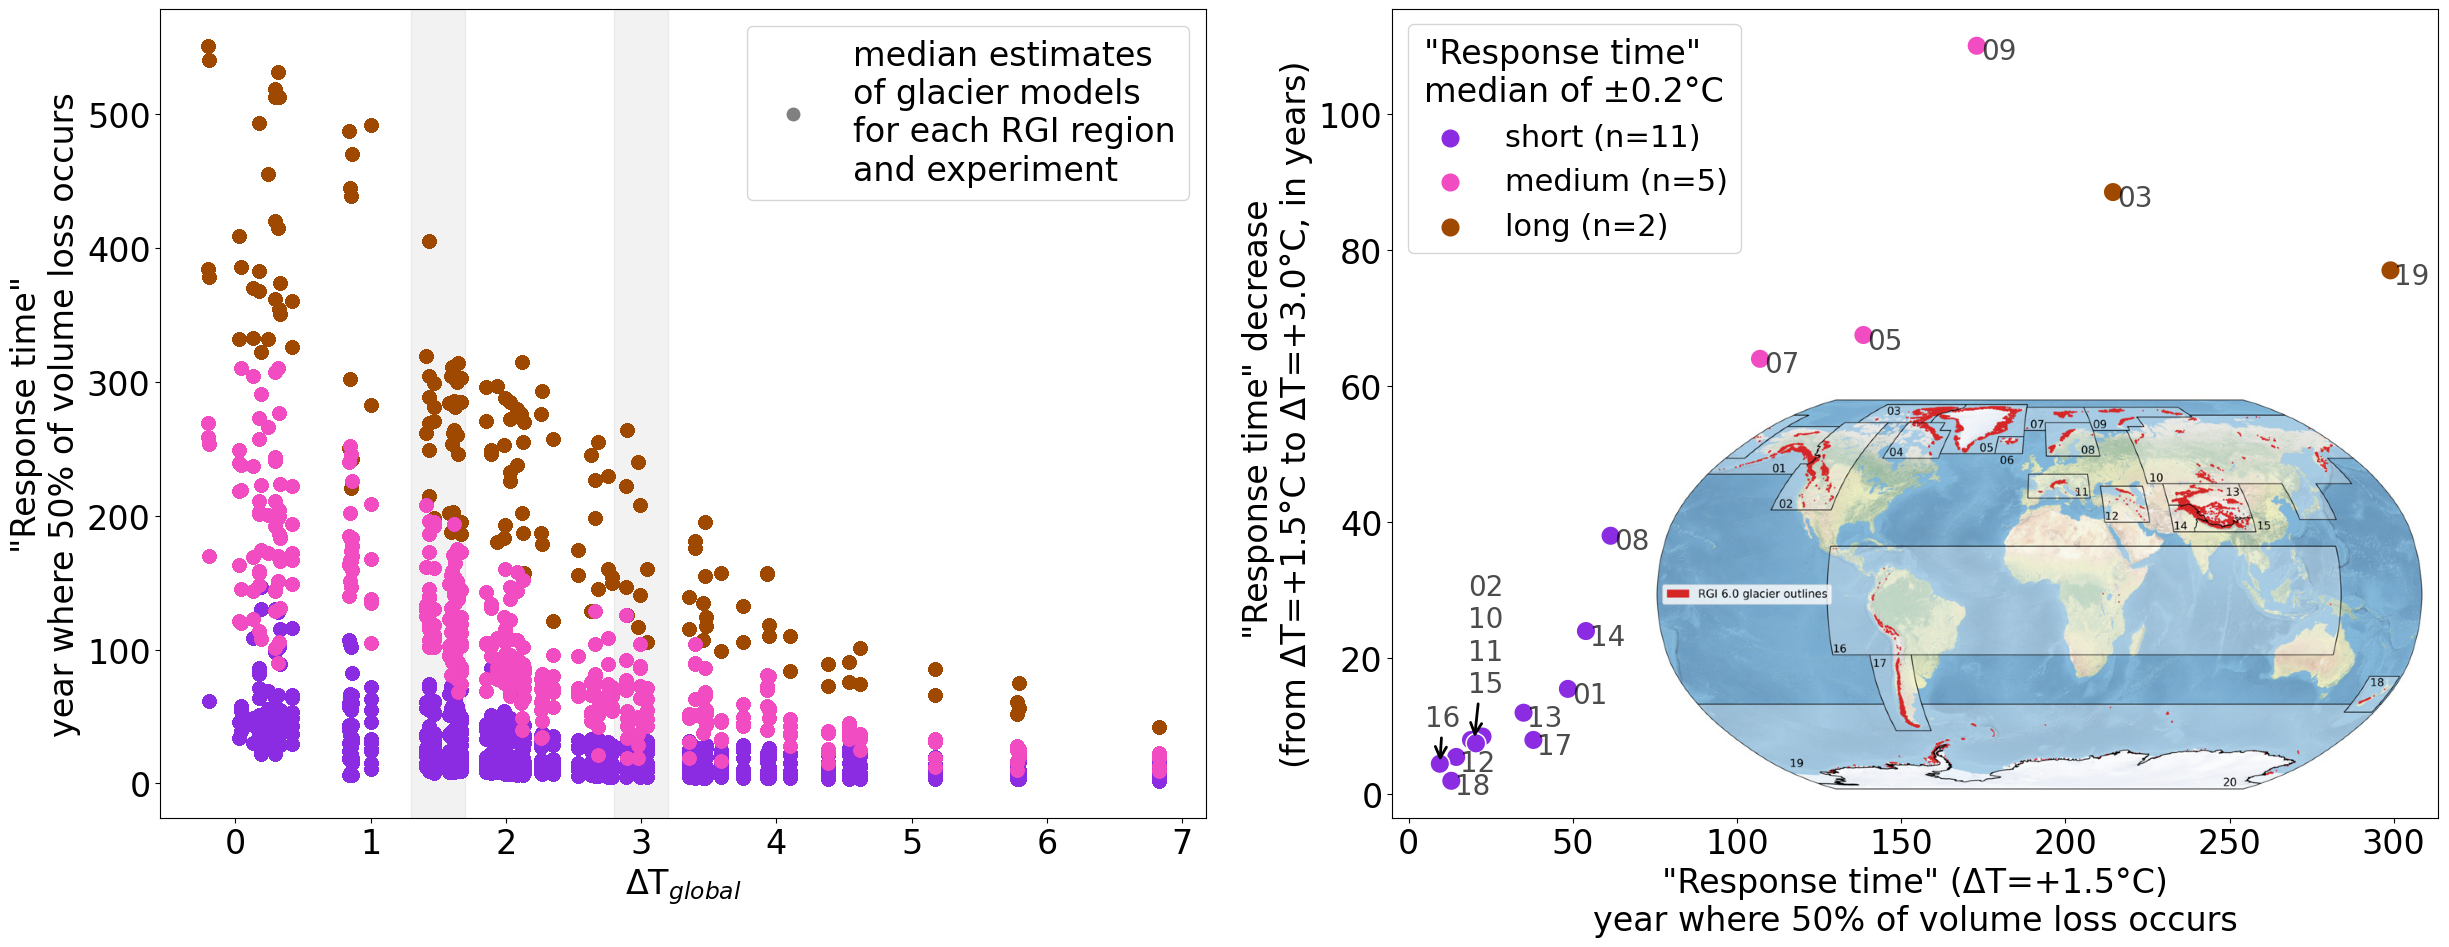

In [95]:
plt.rc('font', size=24)  
# from https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
def plotlabel(xvar, yvar, label):
    ax.text(xvar+1.2, yvar-2, label[3:], alpha=0.7, fontsize=20)

plt.figure(figsize=(25,10))
rgi_reg_per_cluster={}
plt.subplot(121)
ax = plt.gca()

for kk in [0,1,2,3,4]:
    _resp_time_deltaT_sel = df_resp_time_deltaT.loc[df_resp_time_deltaT[f'kmeans_cluster_{k}'] == kk]
    for reg in _resp_time_deltaT_sel.rgi_reg:
        pd_sel_reg = _resp_time_deltaT_sel.loc[_resp_time_deltaT_sel.rgi_reg==reg]
        ax.plot(pd_sel_reg['temp_ch_ipcc'], pd_sel_reg['resp_time_-50%'], 'o', markersize=9,
                color=sns.color_palette('bright')[4:][kk], alpha = 0.6)
    n_clusters = len(_resp_time_deltaT_sel.rgi_reg.unique())
    if n_clusters>0:
        rgi_reg_per_cluster[kk] = n_clusters
plt.ylabel('"Response time"\nyear where 50% of volume loss occurs')
ax.set_xlabel(r'ΔT$_{global}$')
plt.axvspan(1.3,1.7, color='grey', alpha = 0.1)
plt.axvspan(2.8,3.2, color='grey', alpha = 0.1)

from matplotlib.lines import Line2D
point = Line2D([0], [0], label='', marker='o', markersize=9, 
         markeredgecolor='grey', markerfacecolor='grey', linestyle='')
plt.legend([point],['median estimates\nof glacier models\nfor each RGI region\nand experiment'], loc='upper right')

plt.subplot(122)
#plt.subplot(133)

plt.tight_layout()
resp_time_deltaT_sel['diff_resp_time_1_5_vs_3_0'] = resp_time_deltaT_sel['resp_time_-50%_1_5_deg'] - resp_time_deltaT_sel['resp_time_-50%_3_0_deg']
ax=sns.scatterplot(data = resp_time_deltaT_sel, x= 'resp_time_-50%_1_5_deg', y='diff_resp_time_1_5_vs_3_0', marker='o',s=200, hue=f'kmeans_cluster_{k}',
                palette=sns.color_palette('bright')[4:])
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('"Response time" (ΔT=+1.5°C)\nyear where 50% of volume loss occurs')
plt.ylabel('"Response time" decrease \n(from ΔT=+1.5°C to ΔT=+3.0°C, in years)')
resp_time_deltaT_sel_l = resp_time_deltaT_sel.loc[(resp_time_deltaT_sel['resp_time_-50%_1_5_deg']>30) | (resp_time_deltaT_sel['resp_time_-50%_1_5_deg']<17)]
resp_time_deltaT_sel_l = resp_time_deltaT_sel_l.loc[resp_time_deltaT_sel_l.index!='RGI16']
resp_time_deltaT_sel_l.apply(lambda x: plotlabel(x['resp_time_-50%_1_5_deg'], x['diff_resp_time_1_5_vs_3_0'],  x['region']), axis=1)

rgis_c = resp_time_deltaT_sel.loc[(resp_time_deltaT_sel['resp_time_-50%_1_5_deg']<23) & (resp_time_deltaT_sel['resp_time_-50%_1_5_deg']>18)].index.values
r_l =''
for r in rgis_c:
    r_l = r_l+r[3:]+'\n'

ax.annotate(r_l[:-1],xy=(20,8), xytext=(18,15), fontsize=20, arrowprops=dict(arrowstyle="->", lw=2), alpha = 0.7)


resp_time_deltaT_sel_16 = resp_time_deltaT_sel.loc[resp_time_deltaT_sel.index=='RGI16']
resp_time_deltaT_sel_16['resp_time_-50%_1_5_deg']
ax.annotate('16',xy=(resp_time_deltaT_sel_16['resp_time_-50%_1_5_deg'],resp_time_deltaT_sel_16['diff_resp_time_1_5_vs_3_0']),
            xytext=(5,10), fontsize=20, arrowprops=dict(arrowstyle="->", lw=2), alpha = 0.7)

labels_l = [f'short (n={rgi_reg_per_cluster[0]})', f'medium (n={rgi_reg_per_cluster[2]})',f'long (n={rgi_reg_per_cluster[1]})']

leg = plt.legend([handles[0], handles[-1], handles[1]], labels_l, 
           title=f'"Response time"\nmedian of ±0.2°C',
           fontsize=22, loc='upper left',markerscale=2)

plt.tight_layout()


# https://towardsdatascience.com/how-to-add-an-image-to-a-matplotlib-plot-in-python-76098becaf53
import matplotlib.image as image
file = "figures/global_map_rgi6_small.jpeg"
logo = image.imread(file)
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)#The OffsetBox is a simple container artist.
#The child artists are meant to be drawn at a relative position to its #parent.
imagebox = OffsetImage(logo, zoom = 0.6)
ax = plt.gca()
#Annotation box for solar pv logo
#Container for the imagebox referring to a specific position *xy*.
ab = AnnotationBbox(imagebox, (310, 0), frameon = False, box_alignment=(1, 0))
ax.add_artist(ab)

plt.savefig(f'figures/3_k_means_clustering/kmeans_clustering_only_response_time_simple_cluster_n={k}.png')
plt.savefig(f'figures/3_k_means_clustering/kmeans_clustering_only_response_time_simple_cluster_n={k}.pdf')

/tmp/ipykernel_3741353/2132356771.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resp_time_deltaT_sel_l['diff_resp_time_1_5_vs_3_0'] = resp_time_deltaT_sel_l['resp_time_-50%_1_5_deg'] - resp_time_deltaT_sel_l['resp_time_-50%_3_0_deg']
/tmp/ipykernel_3741353/2132356771.py:6: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  ax=sns.scatterplot(data = resp_time_deltaT_sel_l, x= 'resp_time_-50%_1_5_deg', y='diff_resp_time_1_5_vs_3_0', marker='o',s=200, hue=f'kmeans_cluster_{k}',


rgi_reg
RGI02    None
RGI10    None
RGI11    None
RGI12    None
RGI15    None
RGI16    None
RGI18    None
dtype: object

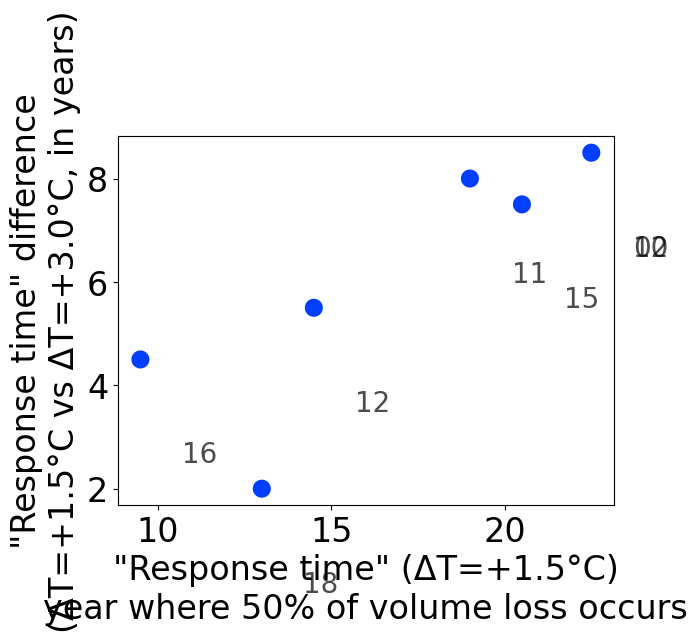

In [96]:
#plt.subplot(122)
#plt.subplot(133)
resp_time_deltaT_sel_l = resp_time_deltaT_sel.loc[resp_time_deltaT_sel['resp_time_-50%_1_5_deg']<30]

resp_time_deltaT_sel_l['diff_resp_time_1_5_vs_3_0'] = resp_time_deltaT_sel_l['resp_time_-50%_1_5_deg'] - resp_time_deltaT_sel_l['resp_time_-50%_3_0_deg']
ax=sns.scatterplot(data = resp_time_deltaT_sel_l, x= 'resp_time_-50%_1_5_deg', y='diff_resp_time_1_5_vs_3_0', marker='o',s=200, hue=f'kmeans_cluster_{k}',
                palette=sns.color_palette('bright'), legend=False)
plt.xlabel('"Response time" (ΔT=+1.5°C)\nyear where 50% of volume loss occurs')
plt.ylabel('"Response time" difference\n(ΔT=+1.5°C vs ΔT=+3.0°C, in years)')
resp_time_deltaT_sel_l.apply(lambda x: plotlabel(x['resp_time_-50%_1_5_deg'], x['diff_resp_time_1_5_vs_3_0'],  x['region']), axis=1)

# OLD

### use complex fit ...

In [ ]:
#**complex fit**
#- too complex: clustering does not seem to work well

pd_exp_decay_fits_adv_5000 = pd_exp_decay_fits_adv.loc[pd_exp_decay_fits_adv.year ==5000]
for var in ['a_comp', 'b_comp', 'c_comp', 'd_comp']:
    pd_exp_decay_fits_adv_5000[var+'_norm'] = sklearn.preprocessing.normalize([pd_exp_decay_fits_adv_5000[var].values]).squeeze()
regions = pd_exp_decay_fits_adv_5000.rgi_reg.values
data = pd_exp_decay_fits_adv_5000[['a_comp_norm', 'b_comp_norm', 'c_comp_norm', 'd_comp_norm']].values

# Perform K-means clustering
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)

# Get the resulting centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Print the resulting centroids and labels
print("Centroids:")
print(centroids)
print("Labels:")
print(labels)

pd_exp_decay_fits_adv_5000[f'kmeans_cluster_{k}'] = labels

fig,axs = plt.subplots(1,4,figsize=(30,10), sharey=True)
for k in [0,1,2,3]:
    pd_sel = pd_exp_decay_fits_adv_5000.loc[pd_exp_decay_fits_adv_5000.kmeans_cluster_4 == k]
    ax = axs[k]
    for reg in pd_sel.rgi_reg:
        pd_sel_reg = pd_sel.loc[pd_sel.rgi_reg==reg]
        a,b,c,d = pd_sel_reg[['a_comp', 'b_comp', 'c_comp', 'd_comp']].values.squeeze()
        ax.plot(glob_temp, exponential_decay_complex(glob_temp,a,b,c,d), label=reg)
        ax.legend()

### use the different time slots ...

In [67]:
pd_exp_decay_fits_simple = pd.read_csv('fitted_glacier_response_to_global_temp_ch_simple.csv', index_col=0)

array(['All', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19'], dtype=object)

In [93]:
year_l = pd_exp_decay_fits_simple.year.unique()
col_l = []
for k in np.arange(0,4):
    col_l.append(f'a_simple_{year_l[k]}')
    col_l.append(f'b_simple_{year_l[k]}')
pd_exp_decay_fits_simple_all = pd.DataFrame(index=pd_exp_decay_fits_simple.rgi_reg.unique(), columns =col_l, data=pd_exp_decay_fits_simple[['a_simple', 'b_simple']].values.reshape(20,8))

In [94]:
pd_exp_decay_fits_simple_all

,a_simple_50,b_simple_50,a_simple_100,b_simple_100,a_simple_500,b_simple_500,a_simple_5000,b_simple_5000
All,103.363877,0.131692,100.865068,0.186778,101.857740,0.638656,103.169744,0.071614
01,99.787629,0.165685,100.921458,0.135449,107.102846,0.224139,106.648187,0.230862
02,124.913497,0.497745,107.000364,0.205159,108.991740,0.630672,106.493193,0.741248
03,138.867361,0.661234,114.635834,0.310045,112.140662,0.211116,107.457947,0.458192
04,171.192168,0.854356,97.713026,0.197416,125.446456,0.422199,103.854910,0.074085
05,102.522175,0.199771,98.060018,0.264158,101.716771,0.874788,103.319102,0.119106
06,93.232239,0.282503,98.319217,0.208126,108.182562,0.348481,104.240985,0.339992
07,139.073484,0.797138,105.926756,0.325712,114.574107,0.834900,106.529023,0.878245
08,148.522406,0.739513,121.909546,0.425014,117.216232,0.301483,108.424181,0.558400
09,196.206925,0.931453,94.298632,0.258077,128.562302,0.453461,104.309516,0.121903


In [96]:
regions = pd_exp_decay_fits_simple_all.index.values
data = pd_exp_decay_fits_simple_all.values

# Perform K-means clustering
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)

# Get the resulting centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Print the resulting centroids and labels
print("Centroids:")
print(centroids)
print("Labels:")
print(labels)

pd_exp_decay_fits_simple_all[f'kmeans_cluster_{k}'] = labels

Centroids:
[[195.39741856   1.10690939  94.43684837   0.44212073 133.02044306
    0.66208525 107.40117944   0.46984368]
 [ 87.7633385    0.34292907  94.85765023   0.27577887 105.53749874
    0.67513862 100.40228859   0.31887732]
 [143.4961843    0.70767473 122.13953524   0.40545155 118.16287226
    0.46986465 108.87006355   0.64133714]]
Labels:
[1 1 2 2 0 1 1 2 2 0 1 1 0 2 0 1 1 0 2 0]


In [97]:
def exponential_decay(x, a, b):
    exp_values_b = -b * x
    return a * np.exp(exp_values_b) #+ c * np.exp(exp_values_d)#**c 

In [103]:
pd_exp_decay_fits_simple_all = pd_exp_decay_fits_simple_all.reset_index()

In [104]:
pd_exp_decay_fits_simple_all

,index,a_simple_50,b_simple_50,a_simple_100,b_simple_100,a_simple_500,b_simple_500,a_simple_5000,b_simple_5000,kmeans_cluster_3
0,All,103.363877,0.131692,100.865068,0.186778,101.857740,0.638656,103.169744,0.071614,1
1,01,99.787629,0.165685,100.921458,0.135449,107.102846,0.224139,106.648187,0.230862,1
2,02,124.913497,0.497745,107.000364,0.205159,108.991740,0.630672,106.493193,0.741248,2
3,03,138.867361,0.661234,114.635834,0.310045,112.140662,0.211116,107.457947,0.458192,2
4,04,171.192168,0.854356,97.713026,0.197416,125.446456,0.422199,103.854910,0.074085,0
5,05,102.522175,0.199771,98.060018,0.264158,101.716771,0.874788,103.319102,0.119106,1
6,06,93.232239,0.282503,98.319217,0.208126,108.182562,0.348481,104.240985,0.339992,1
7,07,139.073484,0.797138,105.926756,0.325712,114.574107,0.834900,106.529023,0.878245,2
8,08,148.522406,0.739513,121.909546,0.425014,117.216232,0.301483,108.424181,0.558400,2
9,09,196.206925,0.931453,94.298632,0.258077,128.562302,0.453461,104.309516,0.121903,0


<AxesSubplot:xlabel='index', ylabel='b_simple_5000'>

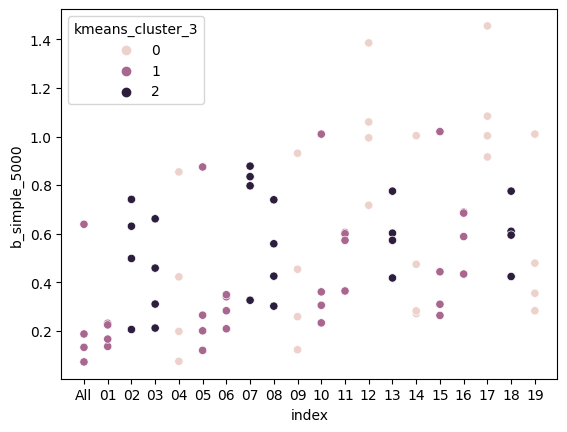

In [113]:
sns.scatterplot(data=pd_exp_decay_fits_simple_all, x='index', y='b_simple_5000', hue='kmeans_cluster_3')
sns.scatterplot(data=pd_exp_decay_fits_simple_all, x='index', y='b_simple_500', hue='kmeans_cluster_3', legend=False)
sns.scatterplot(data=pd_exp_decay_fits_simple_all, x='index', y='b_simple_100', hue='kmeans_cluster_3', legend=False)
sns.scatterplot(data=pd_exp_decay_fits_simple_all, x='index', y='b_simple_50', hue='kmeans_cluster_3', legend=False)

In [115]:
pd_exp_decay_fits_simple

,rgi_reg,year,a_simple,b_simple
0,All,50,103.363877,0.131692
1,01,50,100.865068,0.186778
2,02,50,101.857740,0.638656
3,03,50,103.169744,0.071614
4,04,50,99.787629,0.165685
...,...,...,...,...
75,15,5000,112.823848,0.609827
76,16,5000,229.377767,1.010184
77,17,5000,89.281170,0.282378
78,18,5000,133.864869,0.478691


ValueError: Could not interpret value `kmeans_cluster_3` for parameter `hue`

<AxesSubplot:xlabel='index', ylabel='a_simple_5000'>

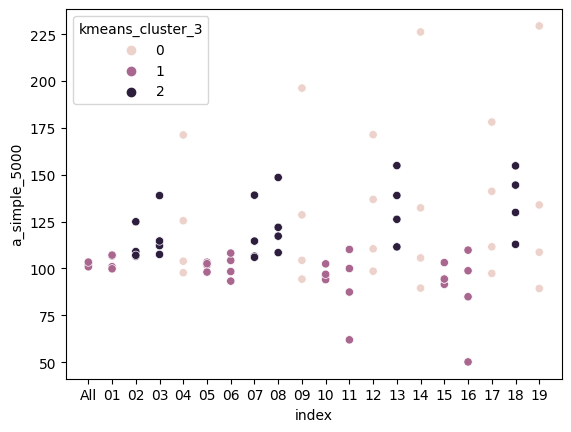

In [114]:
sns.scatterplot(data=pd_exp_decay_fits_simple_all, x='index', y='a_simple_5000', hue='kmeans_cluster_3')
sns.scatterplot(data=pd_exp_decay_fits_simple_all, x='index', y='a_simple_500', hue='kmeans_cluster_3', legend=False)
sns.scatterplot(data=pd_exp_decay_fits_simple_all, x='index', y='a_simple_100', hue='kmeans_cluster_3', legend=False)
sns.scatterplot(data=pd_exp_decay_fits_simple_all, x='index', y='a_simple_50', hue='kmeans_cluster_3', legend=False)

<AxesSubplot:xlabel='index', ylabel='a_simple_5000'>

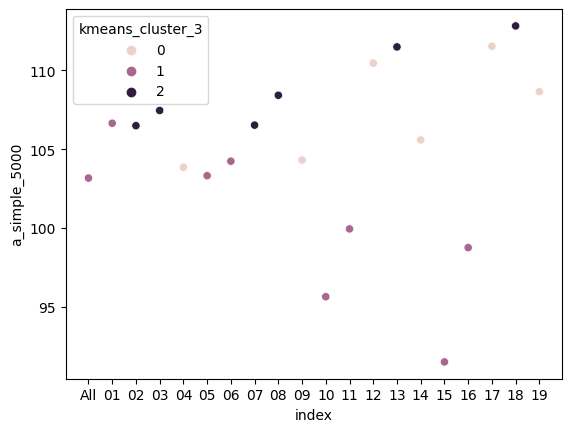

In [109]:
sns.scatterplot(data=pd_exp_decay_fits_simple_all, x='index', y='a_simple_5000', hue='kmeans_cluster_3')

KeyError: "None of [Index(['a_simple', 'b_simple'], dtype='object')] are in the [columns]"

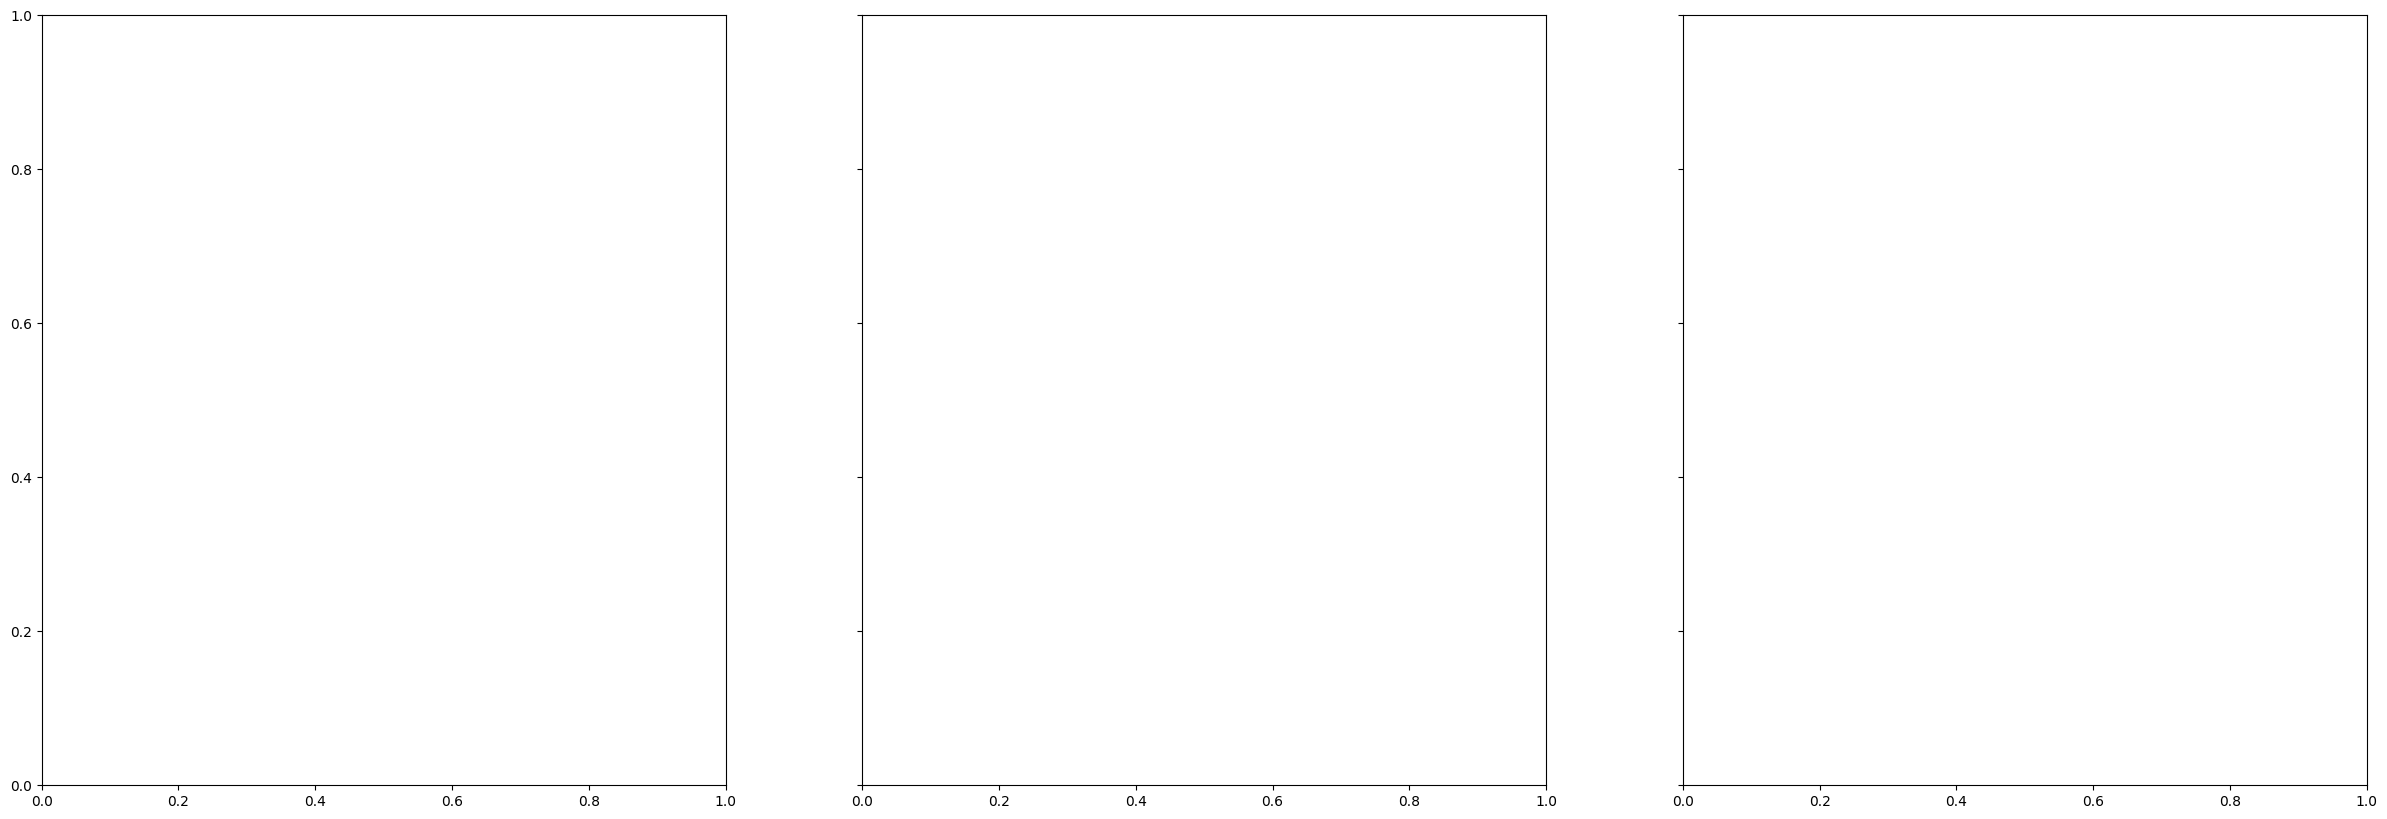

In [100]:
fig,axs = plt.subplots(1,3,figsize=(30,10), sharey=True)
for k in [0,1,2]:
    pd_sel = pd_exp_decay_fits_simple_all.loc[pd_exp_decay_fits_simple_all.kmeans_cluster_3 == k]
    ax = axs[k]
    for reg in pd_sel.index:
        pd_sel_reg = pd_sel.loc[pd_sel.index==reg]
        a,b = pd_sel_reg[['a_simple', 'b_simple']].values.squeeze()
        ax.plot(glob_temp, exponential_decay(glob_temp,a,b), label=reg)
        ax.legend()

## OLD

/tmp/ipykernel_59450/2576527745.py:9: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(data=df, x='a_simple', y='b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('tab10'), s=200)
/tmp/ipykernel_59450/2576527745.py:18: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax=sns.scatterplot(data=df, x=r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]', y=r'b_simple', s=200,


ValueError: Could not interpret value `ΔT(ΔV=0.5*V$_{eq,rel,ΔT=+1.1°C}$) [in °C]` for parameter `y`

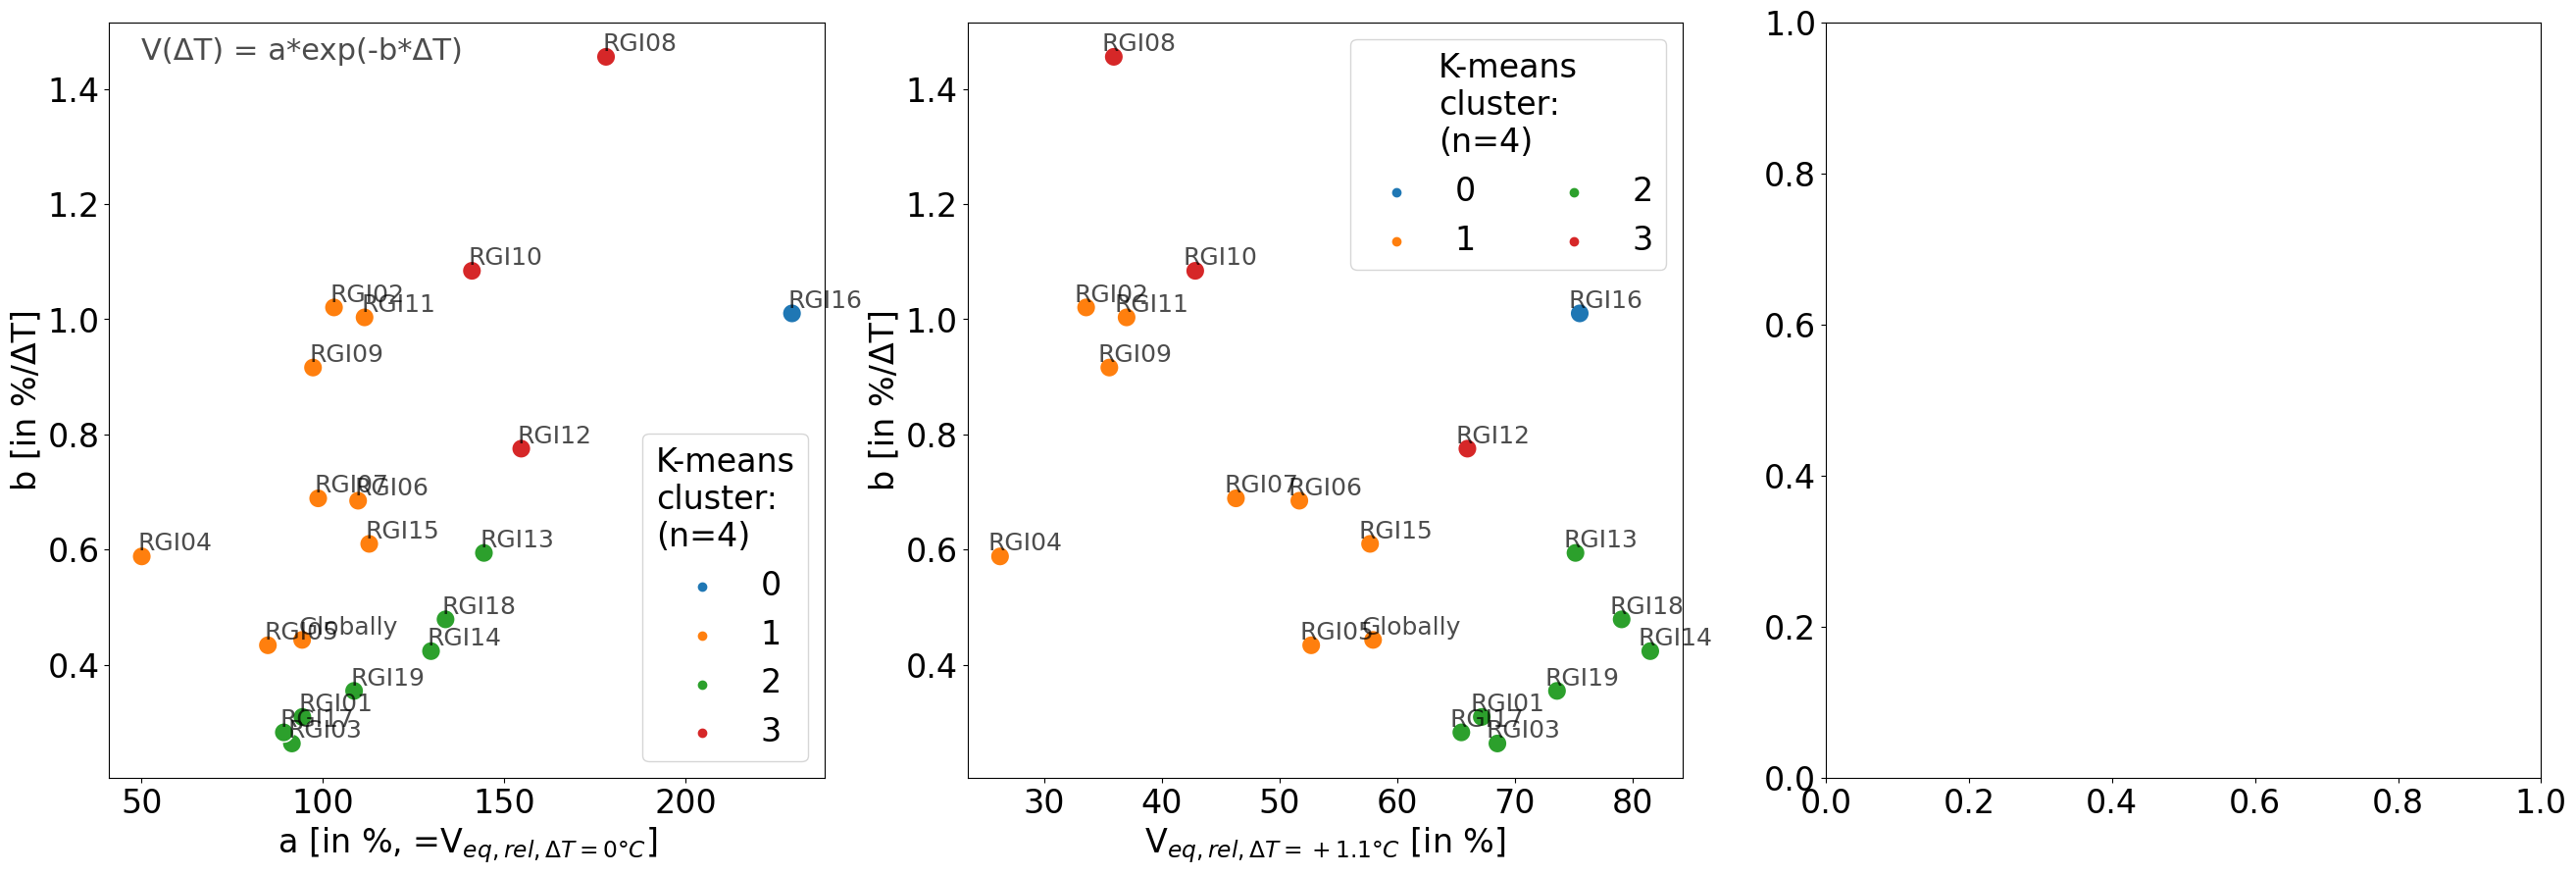

In [272]:

df = pd_exp_decay_fits_simple_5000_values
# from https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
def plotlabel(xvar, yvar, label):
    ax.text(xvar-1, yvar+0.01, label, alpha=0.7, fontsize=18)
plt.rc('font', size=24)  

plt.figure(figsize=(32,10))
plt.subplot(131)
ax = sns.scatterplot(data=df, x='a_simple', y='b_simple', hue='kmeans_cluster_4', palette=sns.color_palette('tab10'), s=200)
df.apply(lambda x: plotlabel(x['a_simple'],  x['b_simple'], x['region']), axis=1)
ax.text(50,1.45, 'V(ΔT) = a*exp(-b*ΔT)', alpha=0.7, fontsize=22)
ax.set_ylabel('b [in %/ΔT]')
ax.set_xlabel(r'a [in %, =V$_{eq,rel,ΔT=0°C}$]')
plt.legend(title='K-means\ncluster:\n(n=4)', loc='lower right')

handles, labels = ax.get_legend_handles_labels()
plt.subplot(132)
ax=sns.scatterplot(data=df, x=r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]', y=r'b_simple', s=200,
                   hue='kmeans_cluster_4', palette=sns.color_palette('tab10'))
ax.set_ylabel('b [in %/ΔT]')
df.apply(lambda x: plotlabel(x[r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]'],  x['b_simple'], x['region']), axis=1)
plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper right',ncol=2)


plt.subplot(133)
ax=sns.scatterplot(data=df, x=r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]', y=r'ΔT(ΔV=0.5*V$_{eq,rel,ΔT=+1.1°C}$) [in °C]', s=200,
                   hue='kmeans_cluster_4', palette=sns.color_palette('tab10'))
df.apply(lambda x: plotlabel(x[r'V$_{eq,rel,ΔT=+1.1°C}$ [in %]'],  x[r'ΔT(ΔV=0.5*V$_{eq,rel,ΔT=+1.1°C}$) [in °C]'], x['region']), axis=1)
plt.legend(title='K-means\ncluster:\n(n=4)', loc='upper left')
plt.tight_layout()